### MOFA+ analysis of Mann group 2017 whole blood and own blood atlas datasets

In [2]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import mudata as md
import muon as mu
import mofax as mfx
import scanpy as sc
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
from pathlib import Path
from datetime import datetime

/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
sns.set_palette("viridis")

In [4]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 200)

In [5]:
date = datetime.now().strftime("%y%m%d")
p = Path().cwd().parent
p_in = p / "data" / "intermediate"
model_path = p / "models"

In [12]:
mdata = md.read_h5mu(p_in / "251020_mudata.h5mu")

/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mudata/_core/mudata.py:963: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push

## 1. Explore MuObject

In [6]:
mdata

MuData object with n_obs × n_vars = 159 × 20000
  obs:	'cell_type', 'lineage'
  4 modalities
    blood_atlas:	153 x 5000
      obs:	'cell_type', 'lineage'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    mann2017:	100 x 5000
      obs:	'cell_type', 'lineage'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    monaco:	18 x 5000
      obs:	'cell_type', 'lineage'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    schmiedel:	10 x 5000
      obs:	'cell_type', 'lineage'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'log1p'

In [7]:
print("Number of features in each modality:")
for modality in mdata.mod_names:
    print(modality, mdata[modality].n_vars)

Number of features in each modality:
blood_atlas 5000
mann2017 5000
monaco 5000
schmiedel 5000


In [8]:
mu.tl.mofa(
    mdata,
    use_obs="union",
    n_factors=15,
    convergence_mode="slow",
    outfile=f"{model_path}/{date}transformed_data_blood_atlas.hdf5",
    save_metadata=True,
    save_data=True,
    verbose=False,
    ard_weights=True,
    ard_factors=True,
    spikeslab_weights=True,
    spikeslab_factors=False,
    gpu_mode=True,
    seed=42,
)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='blood_atlas' group='group1' with N=159 samples and D=5000 features...
Loaded view='mann2017' group='group1' with N=159 samples and D=5000 features...
Loaded view='monaco' group='group1' with N=159 samples and D=5000 features...
Loaded view='schmiedel' group='group1' with N=159 samples and D=5000 features...


Model options:
- Automatic Relevance Determination prior 


Converged!



#######################
## Training finished ##
#######################


Saving model in /home/t.afanasyeva/multimodal_blood_atlas/models/251021transformed_data_blood_atlas.hdf5...
Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].


In [7]:
model = mfx.mofa_model(model_path / f"{date}transformed_data_blood_atlas.hdf5")
model

MOFA+ model: 251021transformed data blood atlas
Samples (cells): 159
Features: 20000
Groups: group1 (159)
Views: blood_atlas (5000), mann2017 (5000), monaco (5000), schmiedel (5000)
Factors: 15
Expectations: W, Z

(<Figure size 1920x1440 with 1 Axes>, <Axes: >)

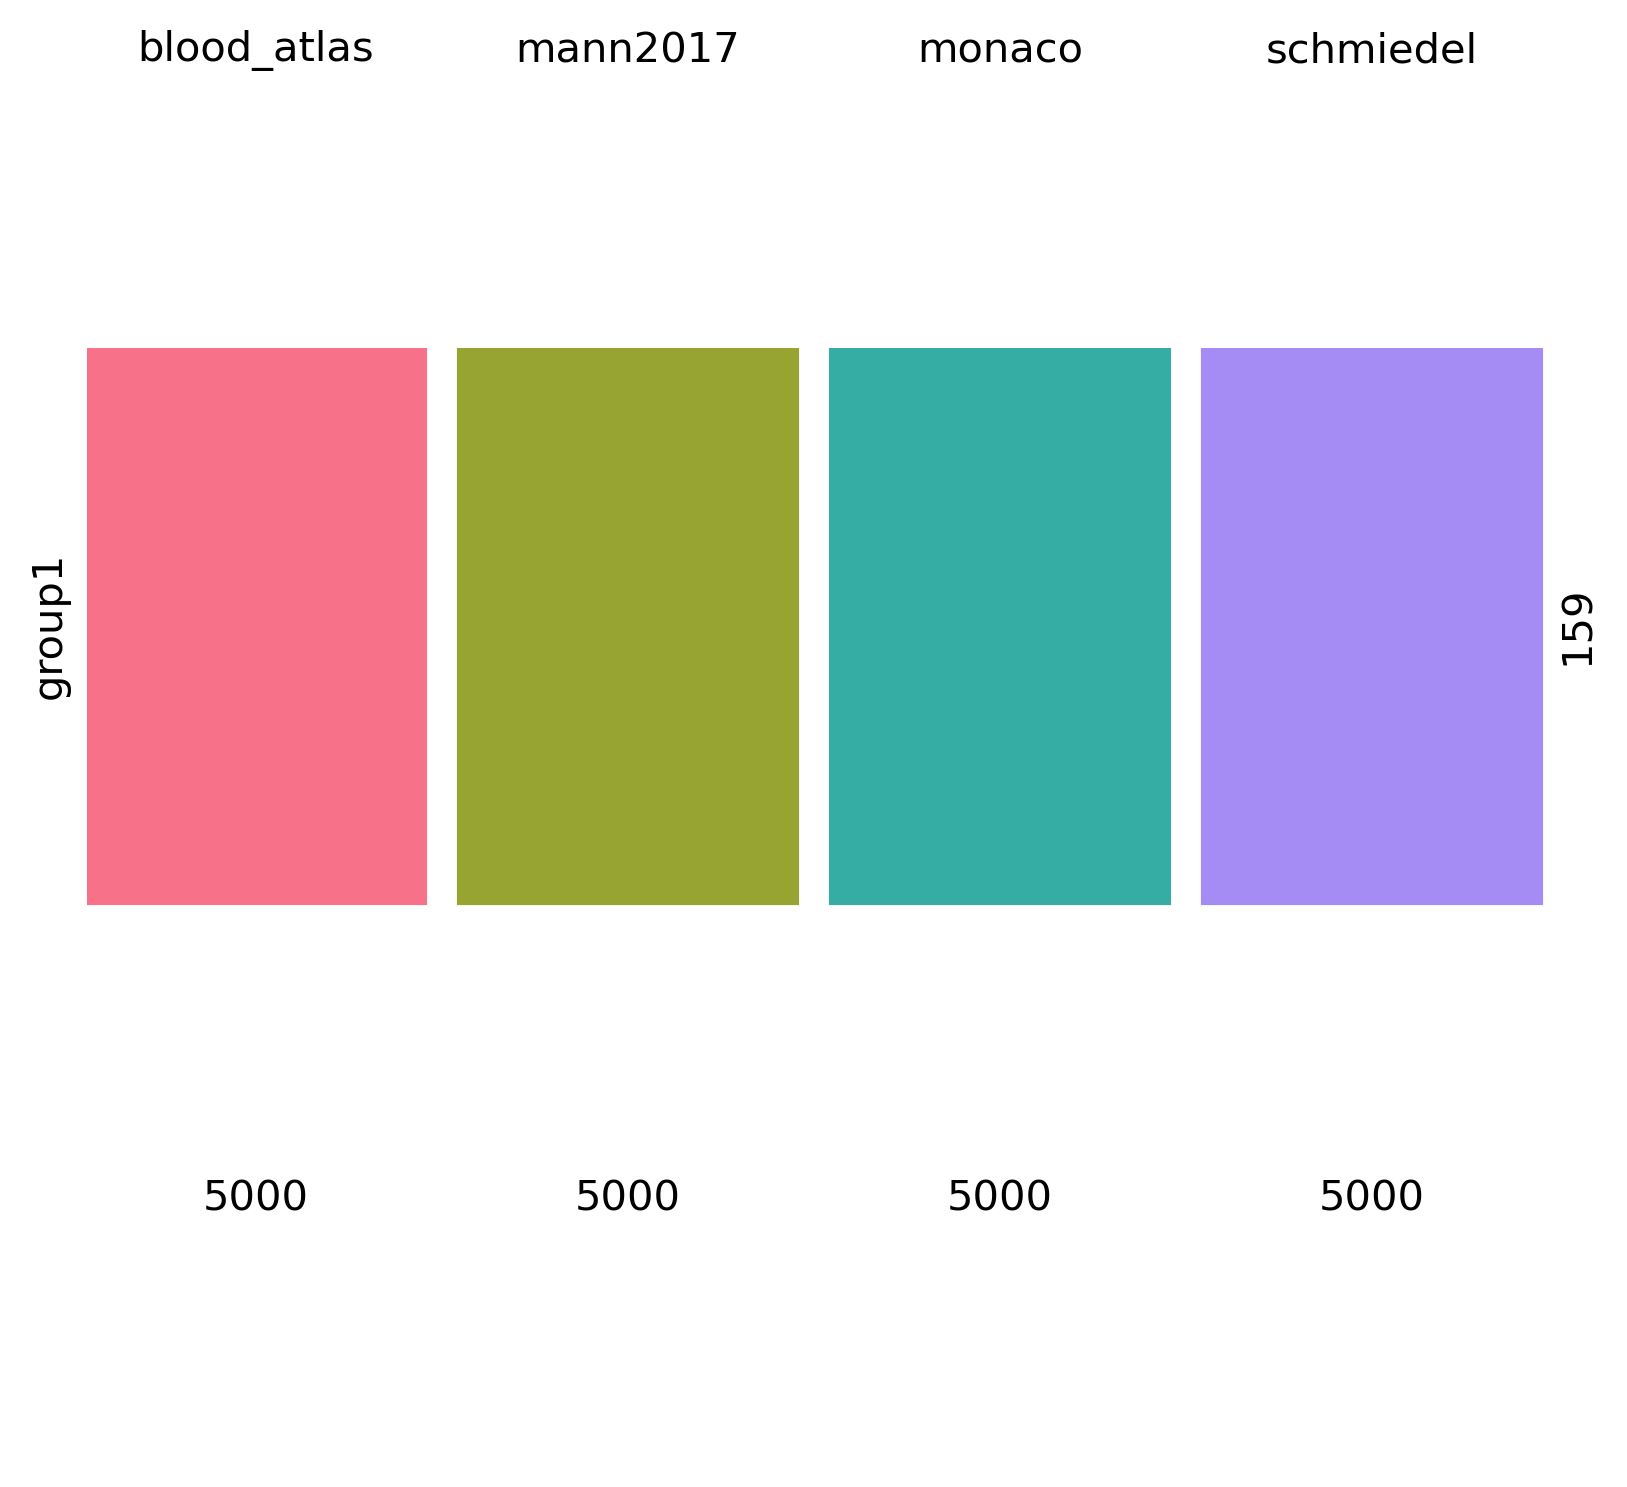

In [7]:
mfx.plot_data_overview(model)

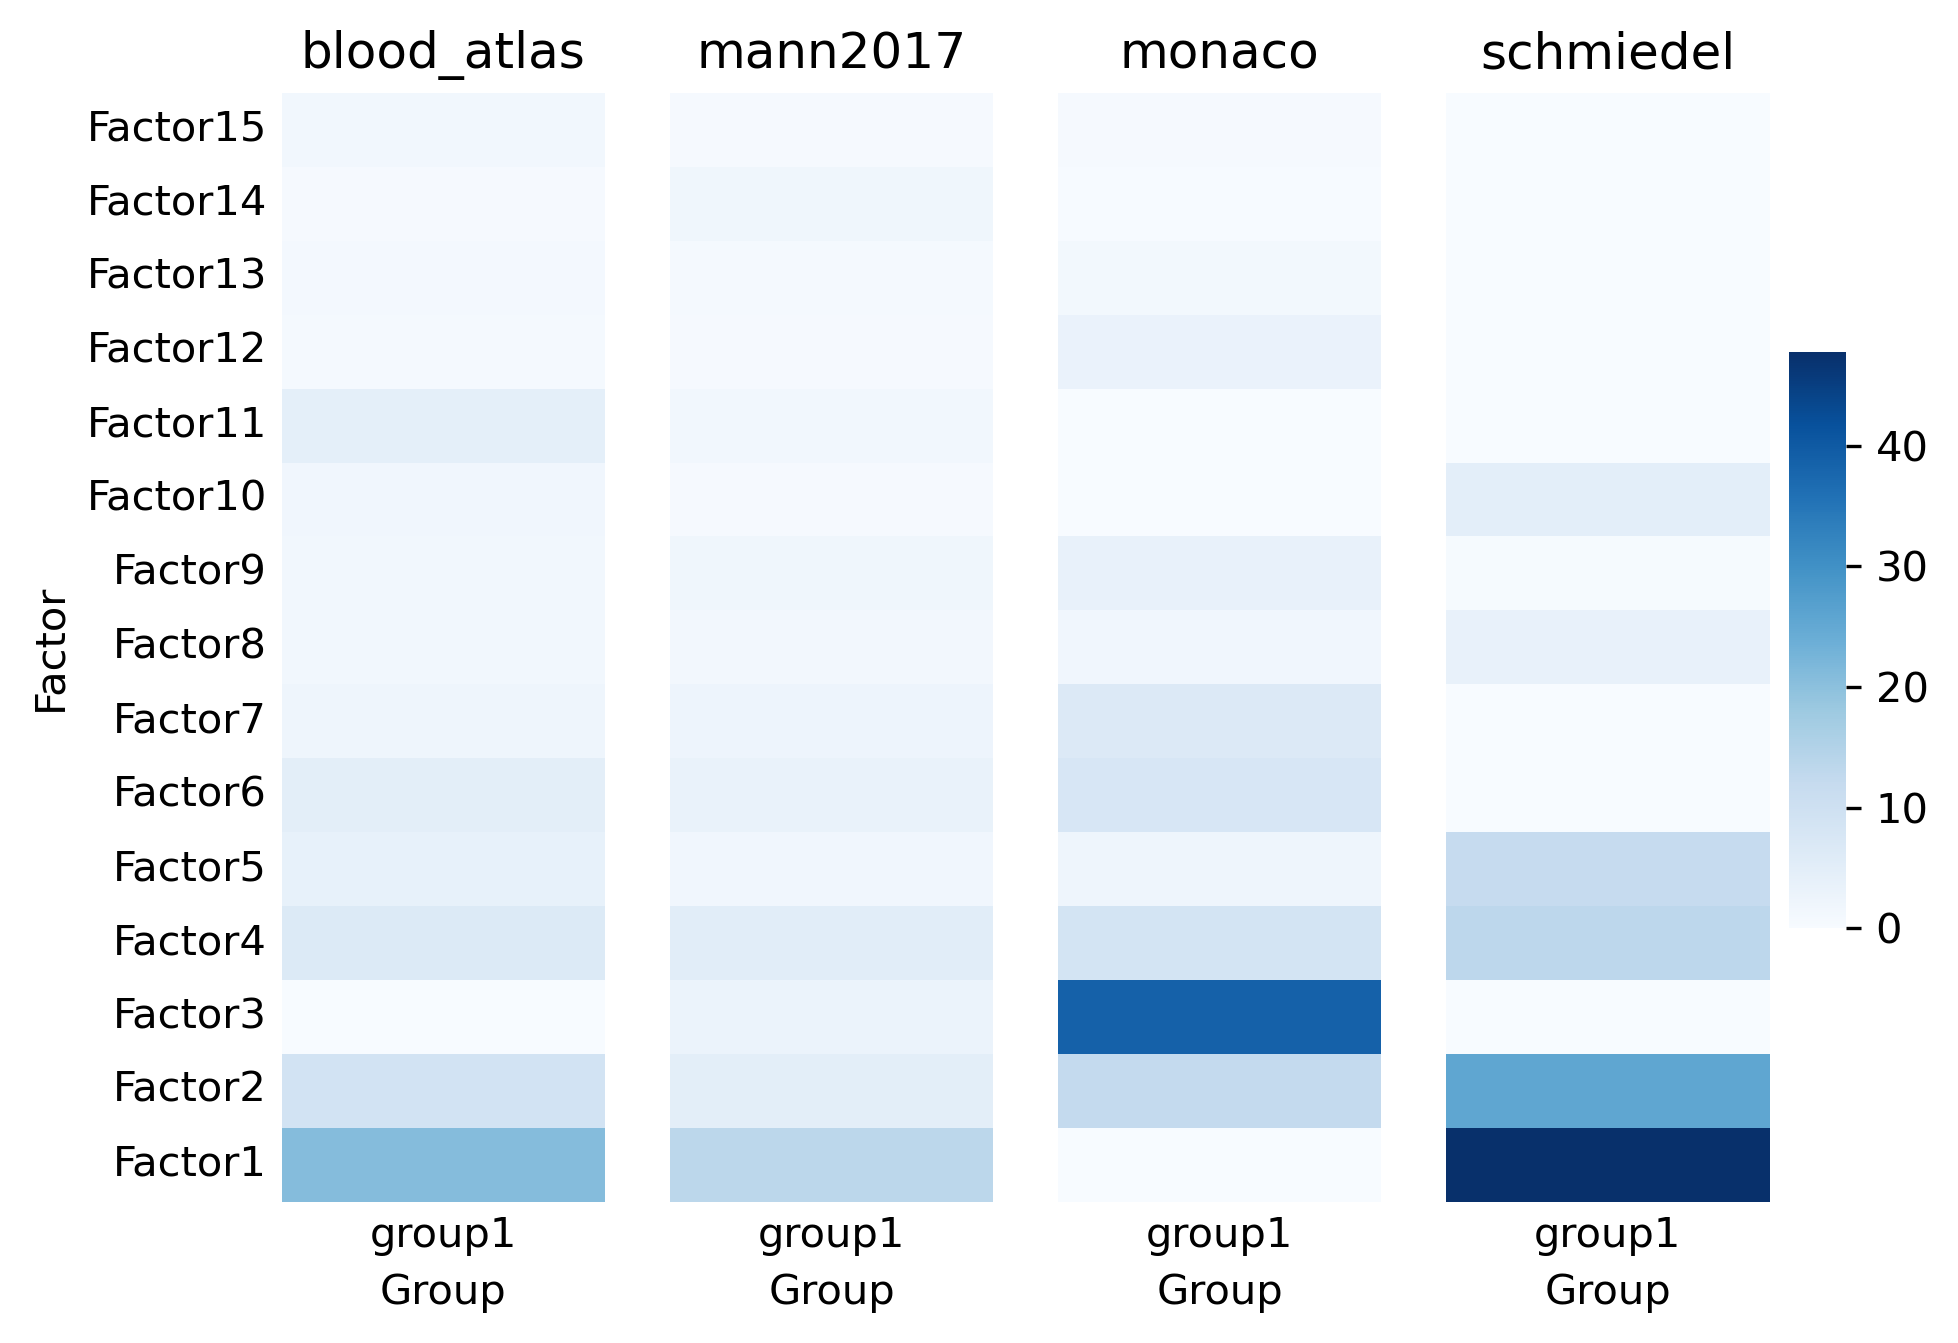

In [8]:
mfx.plot_r2(model)

<Axes: >

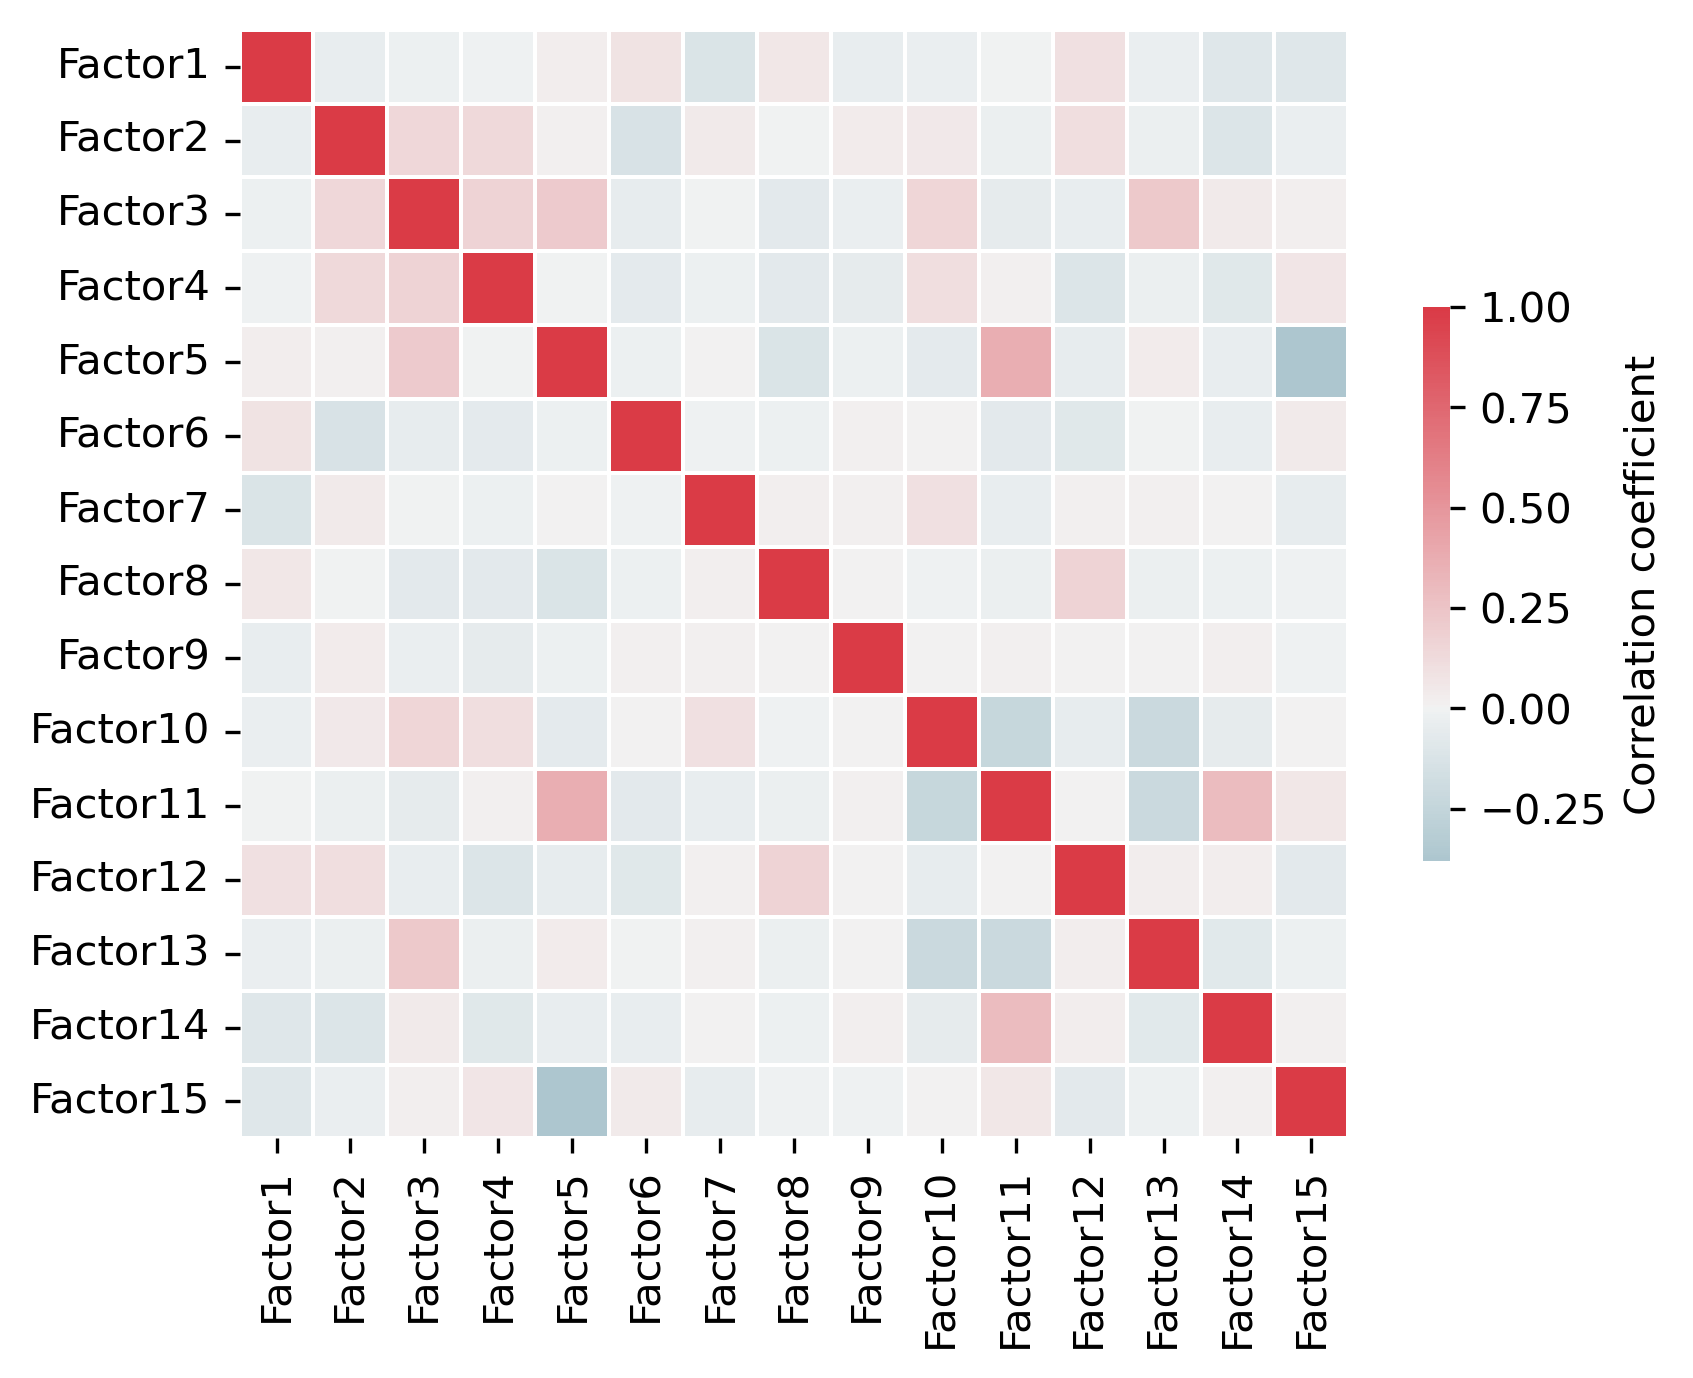

In [9]:
mfx.plot_factors_correlation(model)

In [10]:
len(mdata.obs["cell_type"].unique())

27

In [ ]:
factor_scores = model.get_factors()
factor_scores_df = pd.DataFrame(
    factor_scores,
    index=model.get_cells()["cell"].values,
    columns=[f"Factor {i}" for i in range(1, factor_scores.shape[1] + 1)],
)

here comment

In [12]:
# pd.Categorical(mdata.obs["cell_type"]).codes
# factor_scores_df["cell_type"] = mdata.obs["cell_type"].values
# sns.pairplot(factor_scores_df, hue="cell_type")

In [25]:
palette = [
    "#003AA3",
    "#7D87B9",
    "#BDC0D3",
    "#D5BBBF",
    "#BD7A87",
    "#8E063B",
    "#4A6FE3",
    "#8595E1",
    "#B5BBE3",
    "#E6AFB9",
    "#E07B91",
    "#E07B91",
    "#D23A66",
    "#11C638",
    "#8DD593",
    "#C6DEC7",
    "#EAD3C6",
    "#EFB688",
    "#EF9505",
    "#0FCFC0",
    "#9CDED6",
    "#D5EAE7",
    "#F3E1EB",
    "#F6C4E1",
    "#F798D2",
    "#797979",
    "#C7C7C7",
]

In [ ]:
order = [
    "Basophil",
    "Basophil",
    "Basophil",
    "Basophil",
    "Basophil",
    "CD4_CentralMemory",
    "CD4_CentralMemory",
    "CD4_CentralMemory",
    "CD4_CentralMemory",
    "CD4_CentralMemory",
    "CD4_CentralMemory",
    "CD4_EffectorMemory",
    "CD4_EffectorMemory",
    "CD4_EffectorMemory",
    "CD4_EffectorMemory",
    "CD4_EffectorMemory",
    "CD4_EffectorMemory",
    "CD4_TEMRA",
    "CD4_TEMRA",
    "CD4_TEMRA",
    "CD4_TEMRA",
    "CD4_TEMRA",
    "CD4_Naive",
    "CD4_Naive",
    "CD4_Naive",
    "CD4_Naive",
    "CD4_Naive",
    "CD4_Naive",
    "CD8_CentralMemory",
    "CD8_CentralMemory",
    "CD8_CentralMemory",
    "CD8_CentralMemory",
    "CD8_CentralMemory",
    "CD8_CentralMemory",
    "CD8_EffectorMemory",
    "CD8_EffectorMemory",
    "CD8_EffectorMemory",
    "CD8_EffectorMemory",
    "CD8_EffectorMemory",
    "CD8_EffectorMemory",
    "CD8_TEMRA",
    "CD8_TEMRA",
    "CD8_TEMRA",
    "CD8_TEMRA",
    "CD8_TEMRA",
    "CD8_TEMRA",
    "CD8_Naive",
    "CD8_Naive",
    "CD8_Naive",
    "CD8_Naive",
    "CD8_Naive",
    "CD8_Naive",
    "Eosinophil",
    "Eosinophil",
    "Eosinophil",
    "Eosinophil",
    "Eosinophil",
    "T_GammaDelta",
    "T_GammaDelta",
    "T_GammaDelta",
    "T_GammaDelta",
    "T_GammaDelta",
    "T_GammaDelta",
    "T_MAIT",
    "T_MAIT",
    "T_MAIT",
    "T_MAIT",
    "T_MAIT",
    "T_MAIT",
    "Monocyte_Nonclassical",
    "Monocyte_Nonclassical",
    "Monocyte_Nonclassical",
    "Monocyte_Nonclassical",
    "Monocyte_Classical",
    "Monocyte_Classical",
    "Monocyte_Classical",
    "Monocyte_Classical",
    "Monocyte_Classical",
    "Monocyte_Classical",
    "Monocyte_Intermediate",
    "Monocyte_Intermediate",
    "Monocyte_Intermediate",
    "Monocyte_Intermediate",
    "Monocyte_Intermediate",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "B_Naive",
    "Neutrophil",
    "Neutrophil",
    "Neutrophil",
    "Neutrophil",
    "Neutrophil",
    "NK_Dim",
    "NK_Dim",
    "NK_Dim",
    "NK_Dim",
    "NK_Dim",
    "NK_Dim",
    "NK_Bright",
    "NK_Bright",
    "NK_Bright",
    "NK_Bright",
    "NK_Bright",
    "NK_Bright",
    "Plasmacytoid_DC",
    "Plasmacytoid_DC",
    "Plasmacytoid_DC",
    "Plasmacytoid_DC",
    "B_Memory",
    "B_Memory",
    "B_Memory",
    "B_Memory",
    "B_Memory",
    "B_Memory",
    "CD4_MemoryTfh",
    "CD4_MemoryTfh",
    "CD4_MemoryTfh",
    "CD4_MemoryTfh",
    "CD4_MemoryTfh",
    "CD4_MemoryTfh",
    "CD4_MemoryTh1",
    "CD4_MemoryTh1",
    "CD4_MemoryTh1",
    "CD4_MemoryTh1",
    "CD4_MemoryTh1",
    "CD4_MemoryTh1",
    "CD4_MemoryTh2",
    "CD4_MemoryTh2",
    "CD4_MemoryTh2",
    "CD4_MemoryTh2",
    "CD4_MemoryTh2",
    "CD4_MemoryTh2",
    "CD4_MemoryTh17",
    "CD4_MemoryTh17",
    "CD4_MemoryTh17",
    "CD4_MemoryTh17",
    "CD4_MemoryTh17",
    "CD4_MemoryTh17",
    "CD4_Treg",
    "CD4_Treg",
    "CD4_Treg",
    "CD4_Treg",
    "CD4_Treg",
    "CD4_Treg",
]

In [22]:
order.sort()

/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mofax/plot_utils.py:121: UserWarning: 
The palette list has fewer values (27) than needed (153) and will cycle, which may produce an uninterpretable plot.
  g = plot_func(


<Axes: title={'center': 'cell_type'}, xlabel='Factor 1', ylabel='Factor 4'>

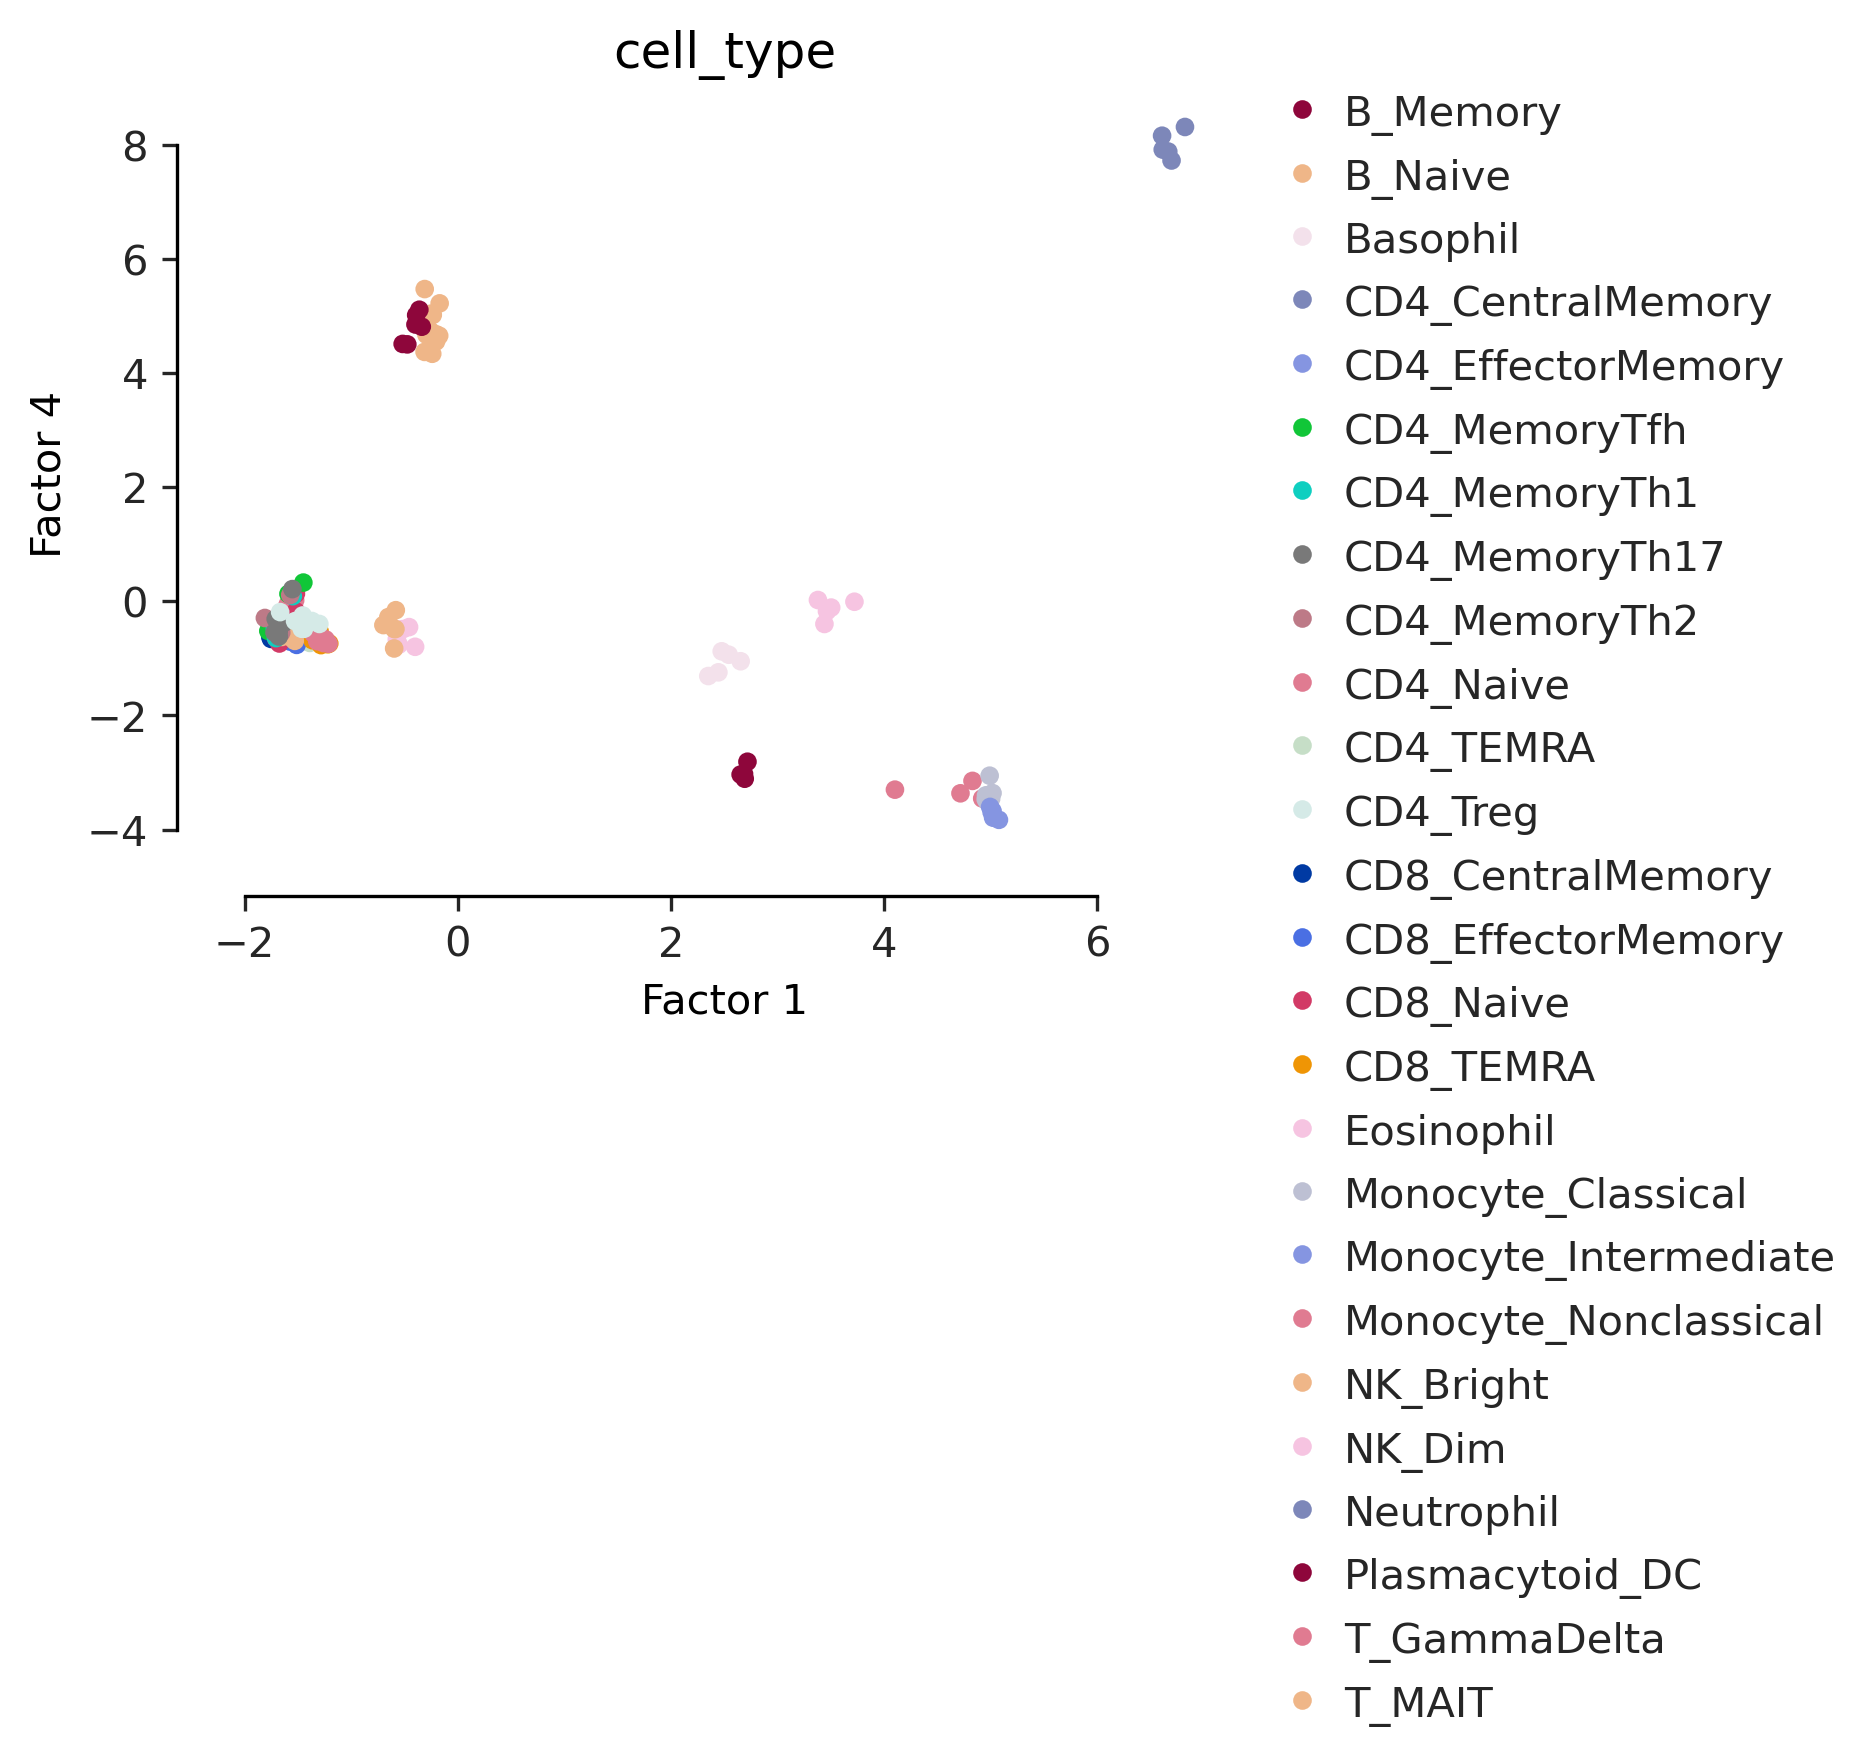

In [ ]:
mfx.plot_factors_scatter(
    model,
    x="Factor 1",
    y="Factor 4",
    color="cell_type",
    palette=palette,
    hue_order=order,
)

<Axes: title={'center': 'lineage'}, xlabel='Factor 1', ylabel='Factor 4'>

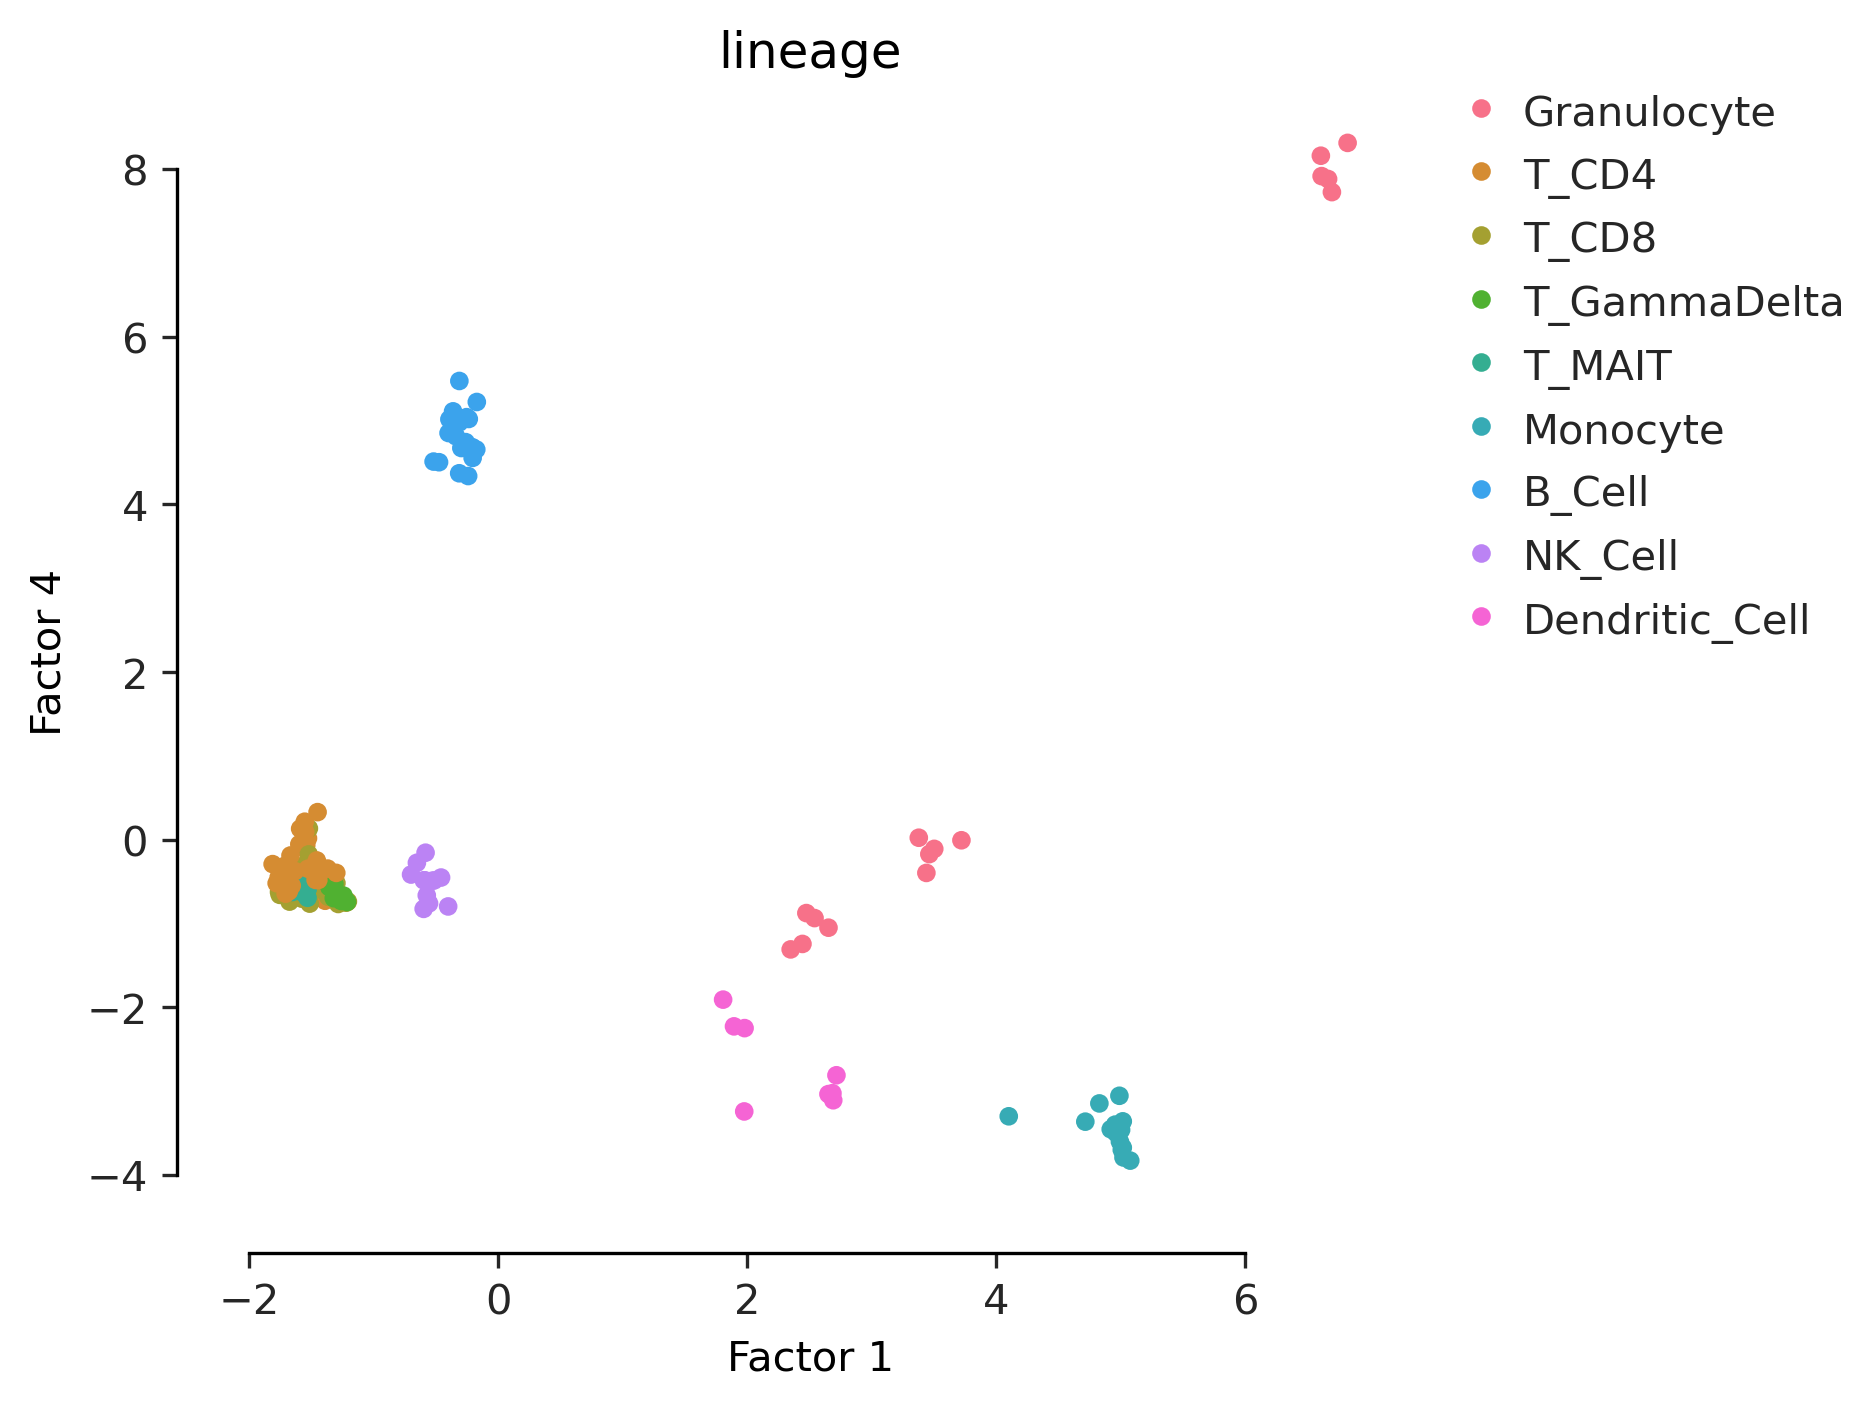

In [14]:
mfx.plot_factors_scatter(model, x="Factor 1", y="Factor 4", color="lineage")

<Axes: >

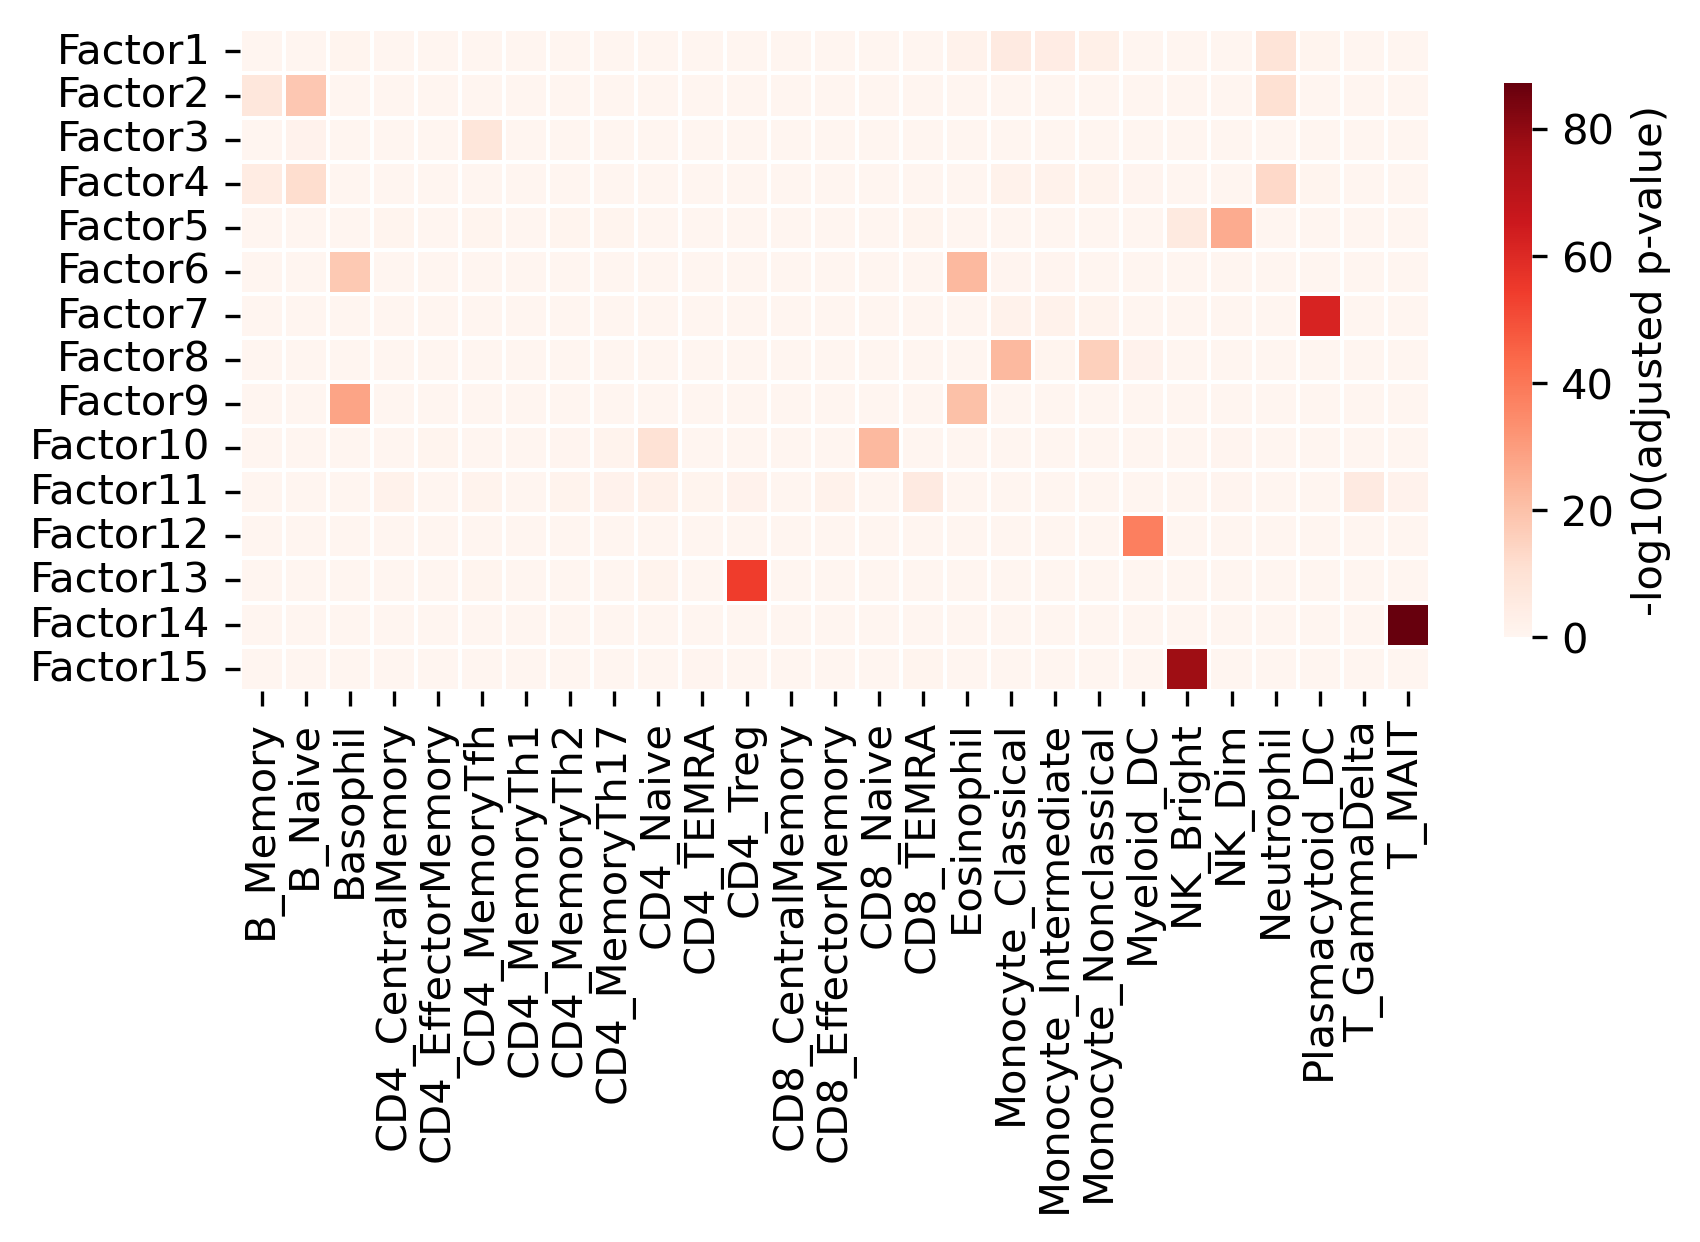

In [15]:
covariates_numeric = pd.get_dummies(mdata.obs["cell_type"])
mfx.plot_factors_covariates_correlation(
    model, covariates=covariates_numeric, pvalues=True
)

In [16]:
# create DataFrames of factor loadings for all existing views
factor_loadings_dfs = {}

# determine views to iterate (try model first, fall back to mdata)
try:
    views = model.get_views()
except Exception:
    try:
        views = model.views
    except Exception:
        views = list(mdata.mod_names)

n_factors = model.get_factors().shape[1]

for view in views:
    try:
        # try to get weights/loadings from the model for this view
        fl = model.get_weights(view)
    except Exception:
        # if model does not expose get_weights(view), skip this view
        print(f"Skipping view {view}: cannot get weights from model")
        continue

    # ensure shape is (n_features, n_factors)
    fl = np.asarray(fl)
    if fl.shape[0] == n_factors and fl.shape[1] != n_factors:
        fl = fl.T

    features = model.get_features(view)["feature"].values
    df = pd.DataFrame(
        fl,
        index=features,
        columns=[f"Factor {i}" for i in range(1, fl.shape[1] + 1)],
    )

    # store in a dict and also expose a variable per view with a safe name
    factor_loadings_dfs[view] = df
    varname = f"factor_loadings_{view}_df".replace(" ", "_").replace("-", "_")
    globals()[varname] = df

# quick report
print("Created factor loadings DataFrames for views:", list(factor_loadings_dfs.keys()))

Created factor loadings DataFrames for views: [np.str_('blood_atlas'), np.str_('mann2017'), np.str_('monaco'), np.str_('schmiedel')]


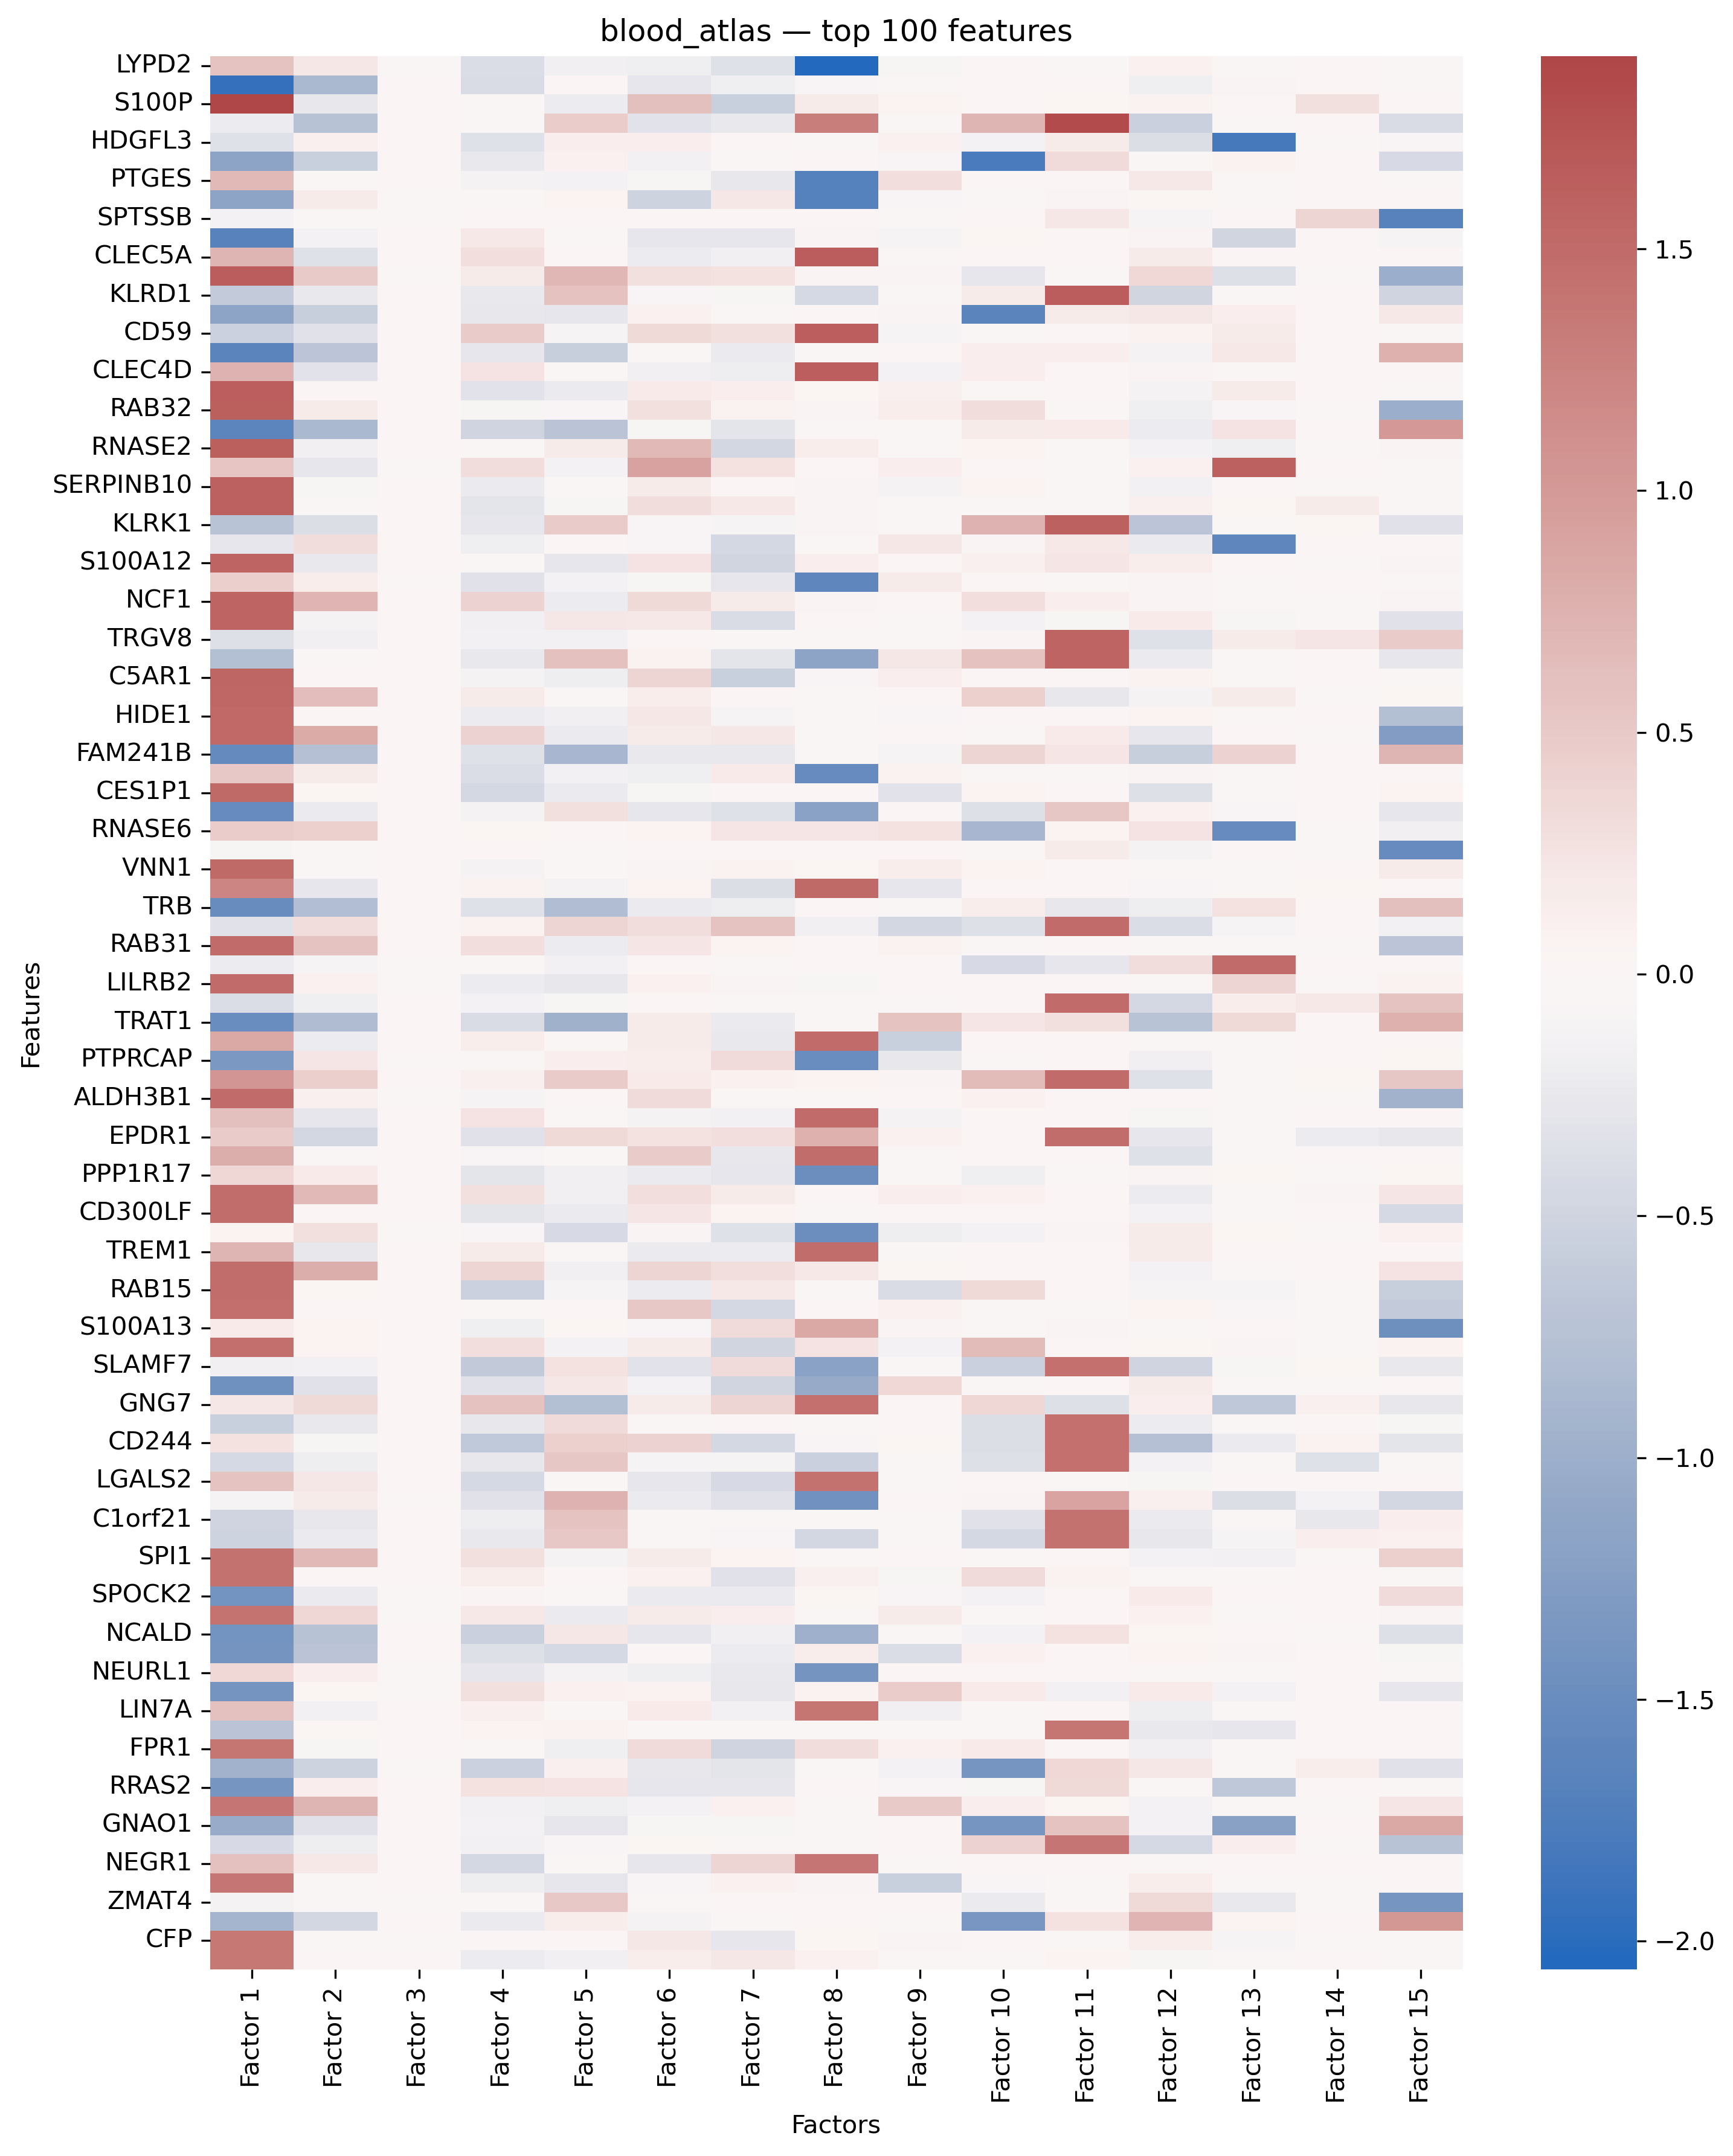

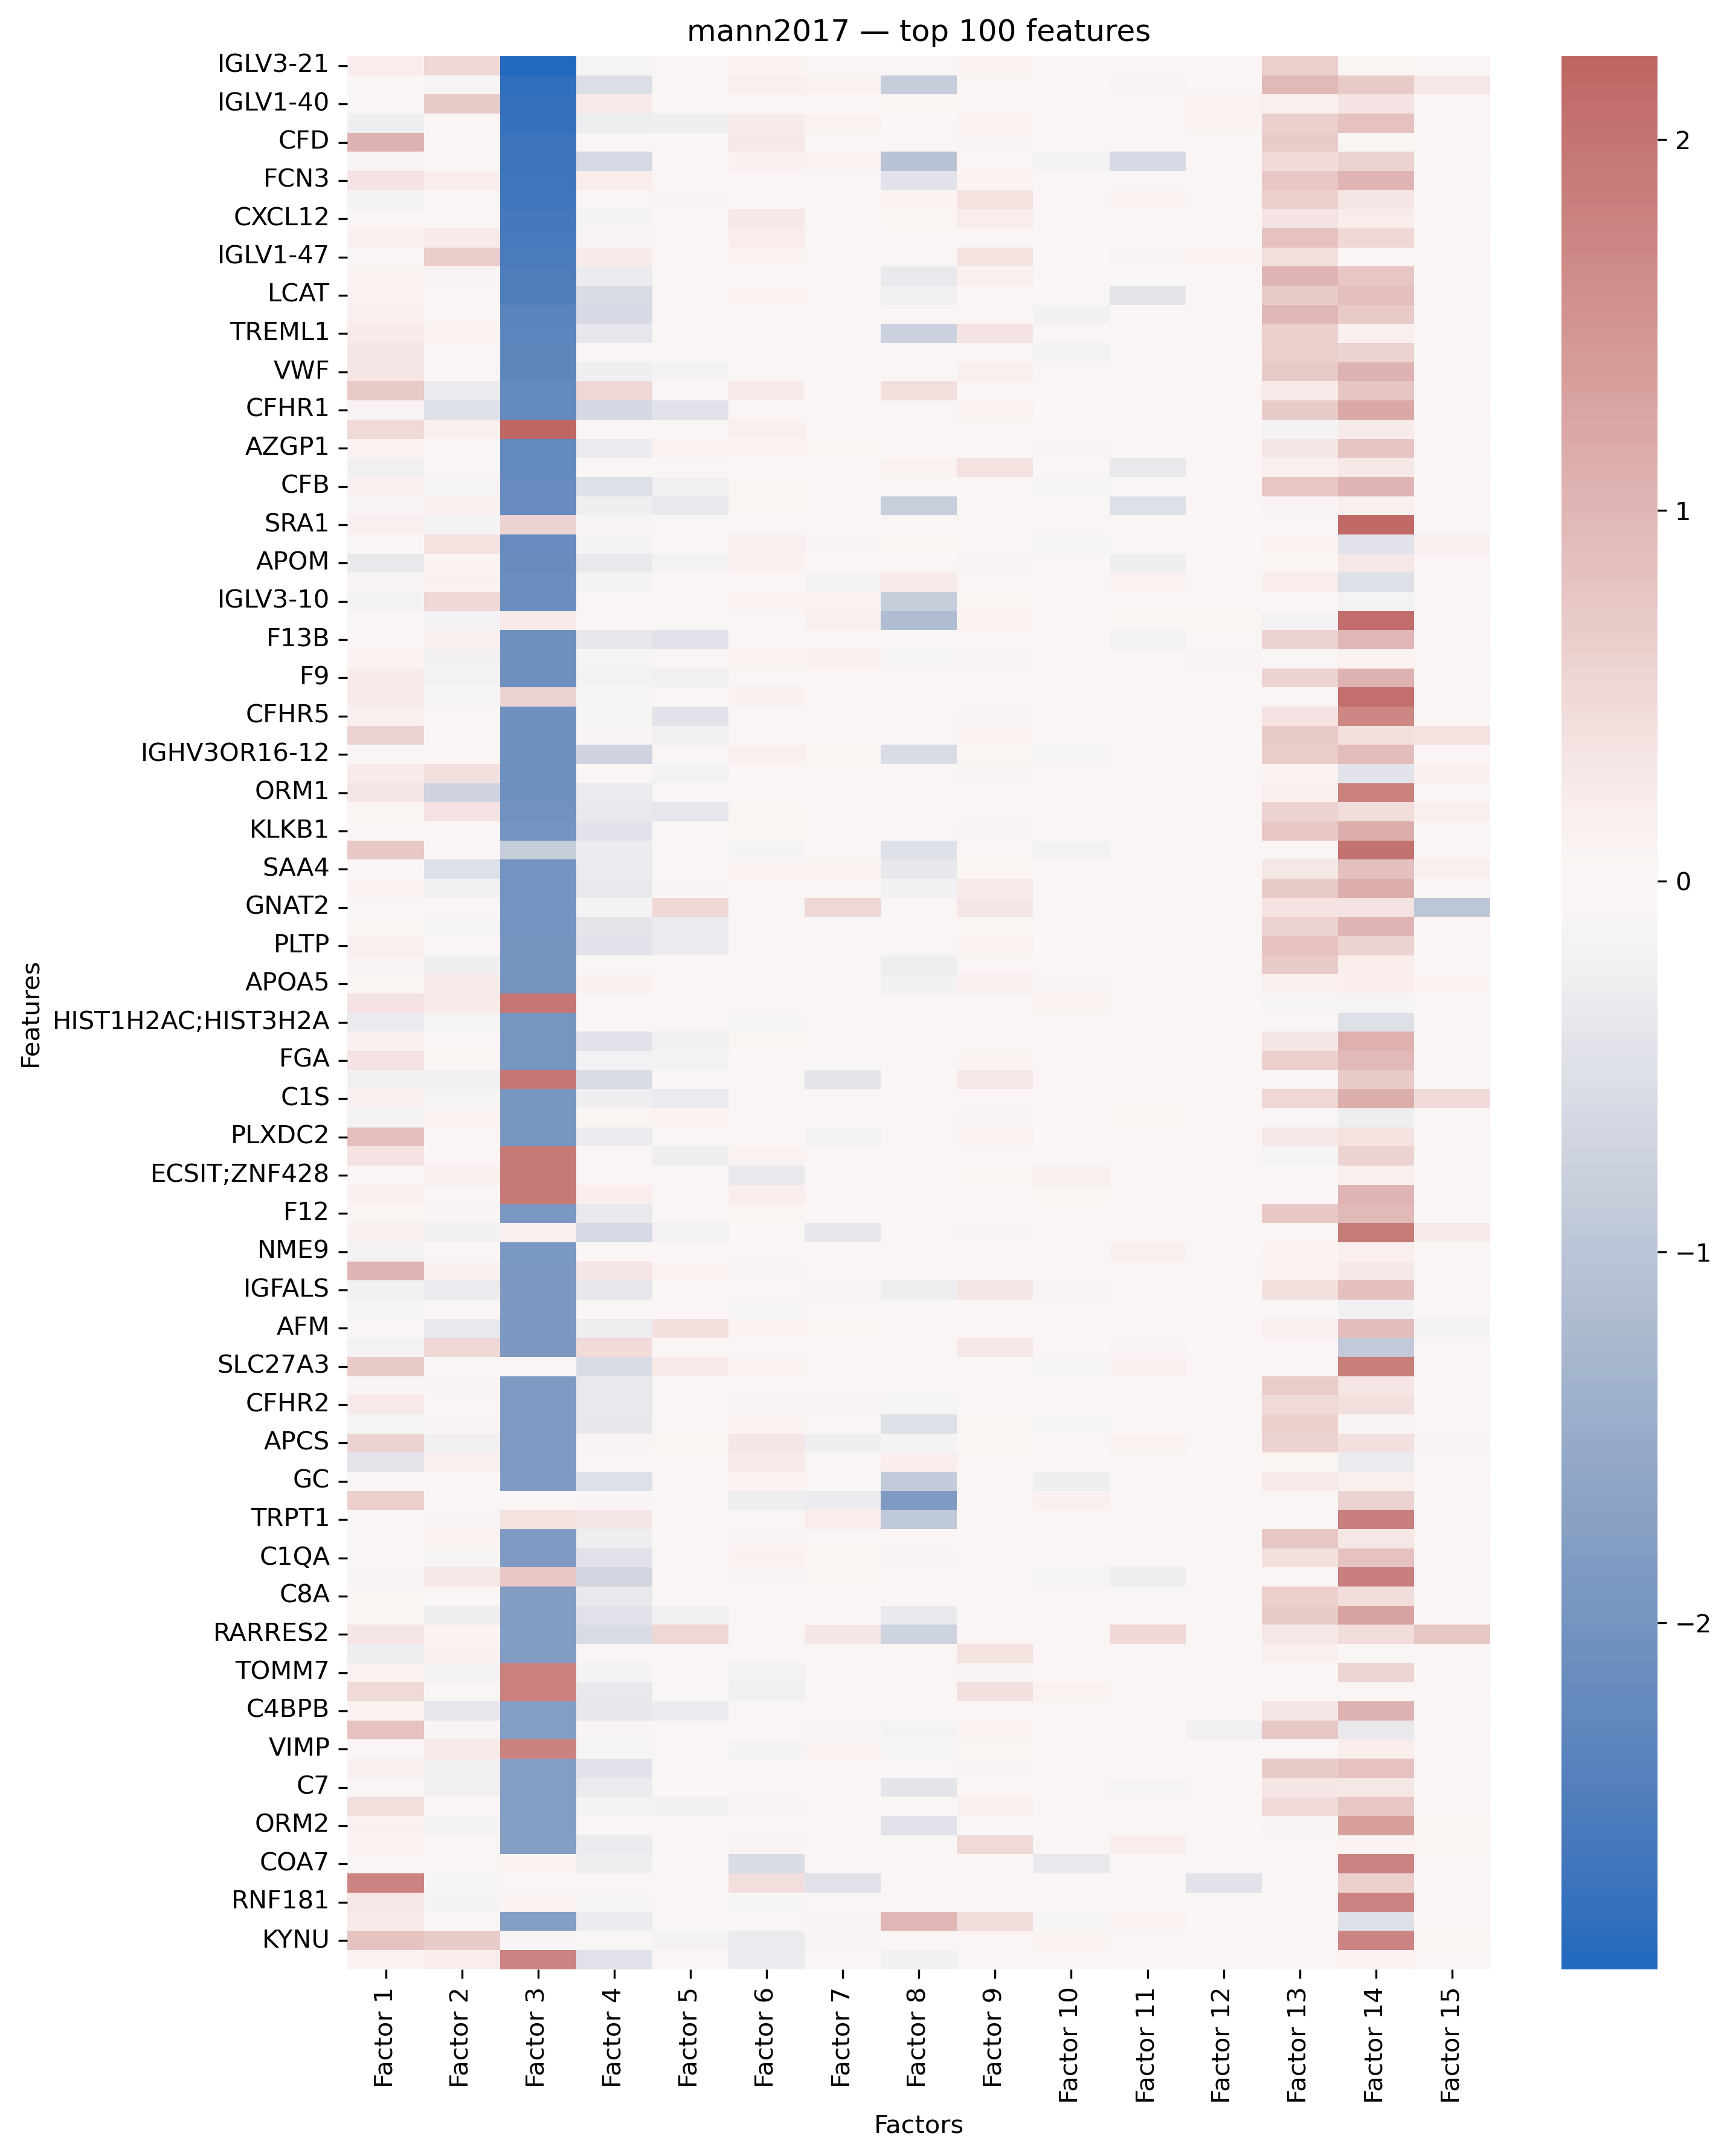

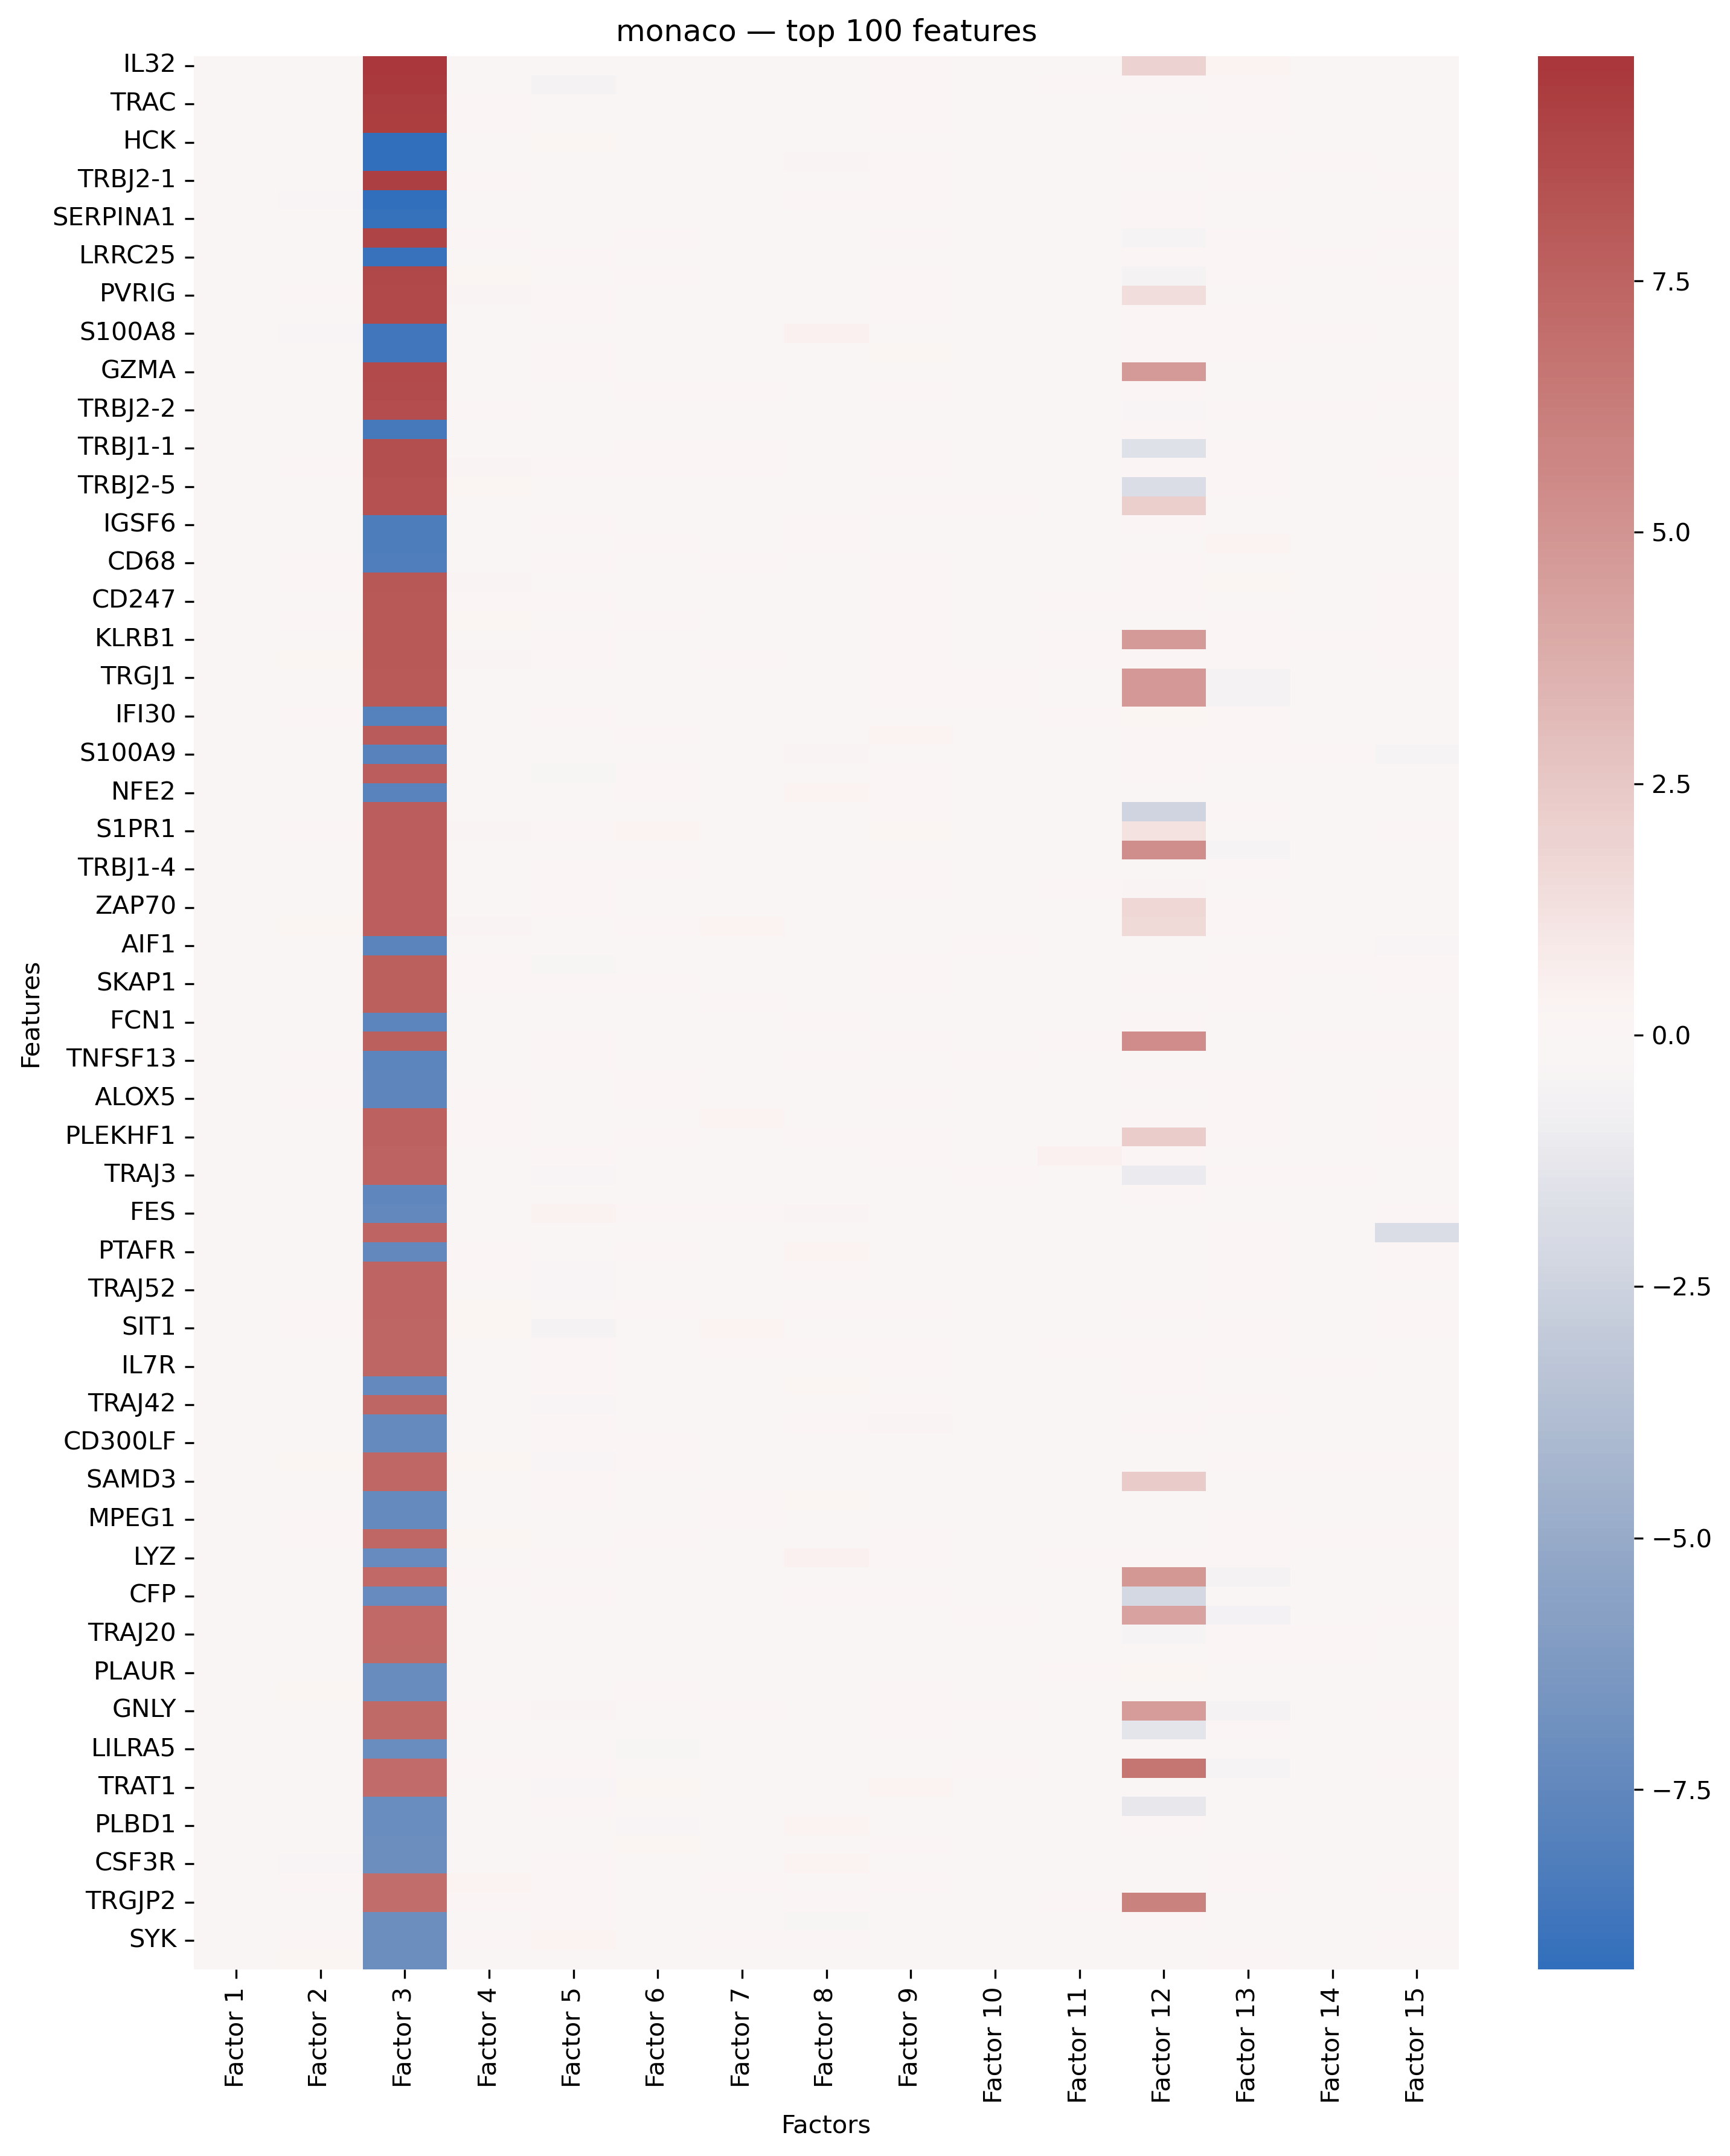

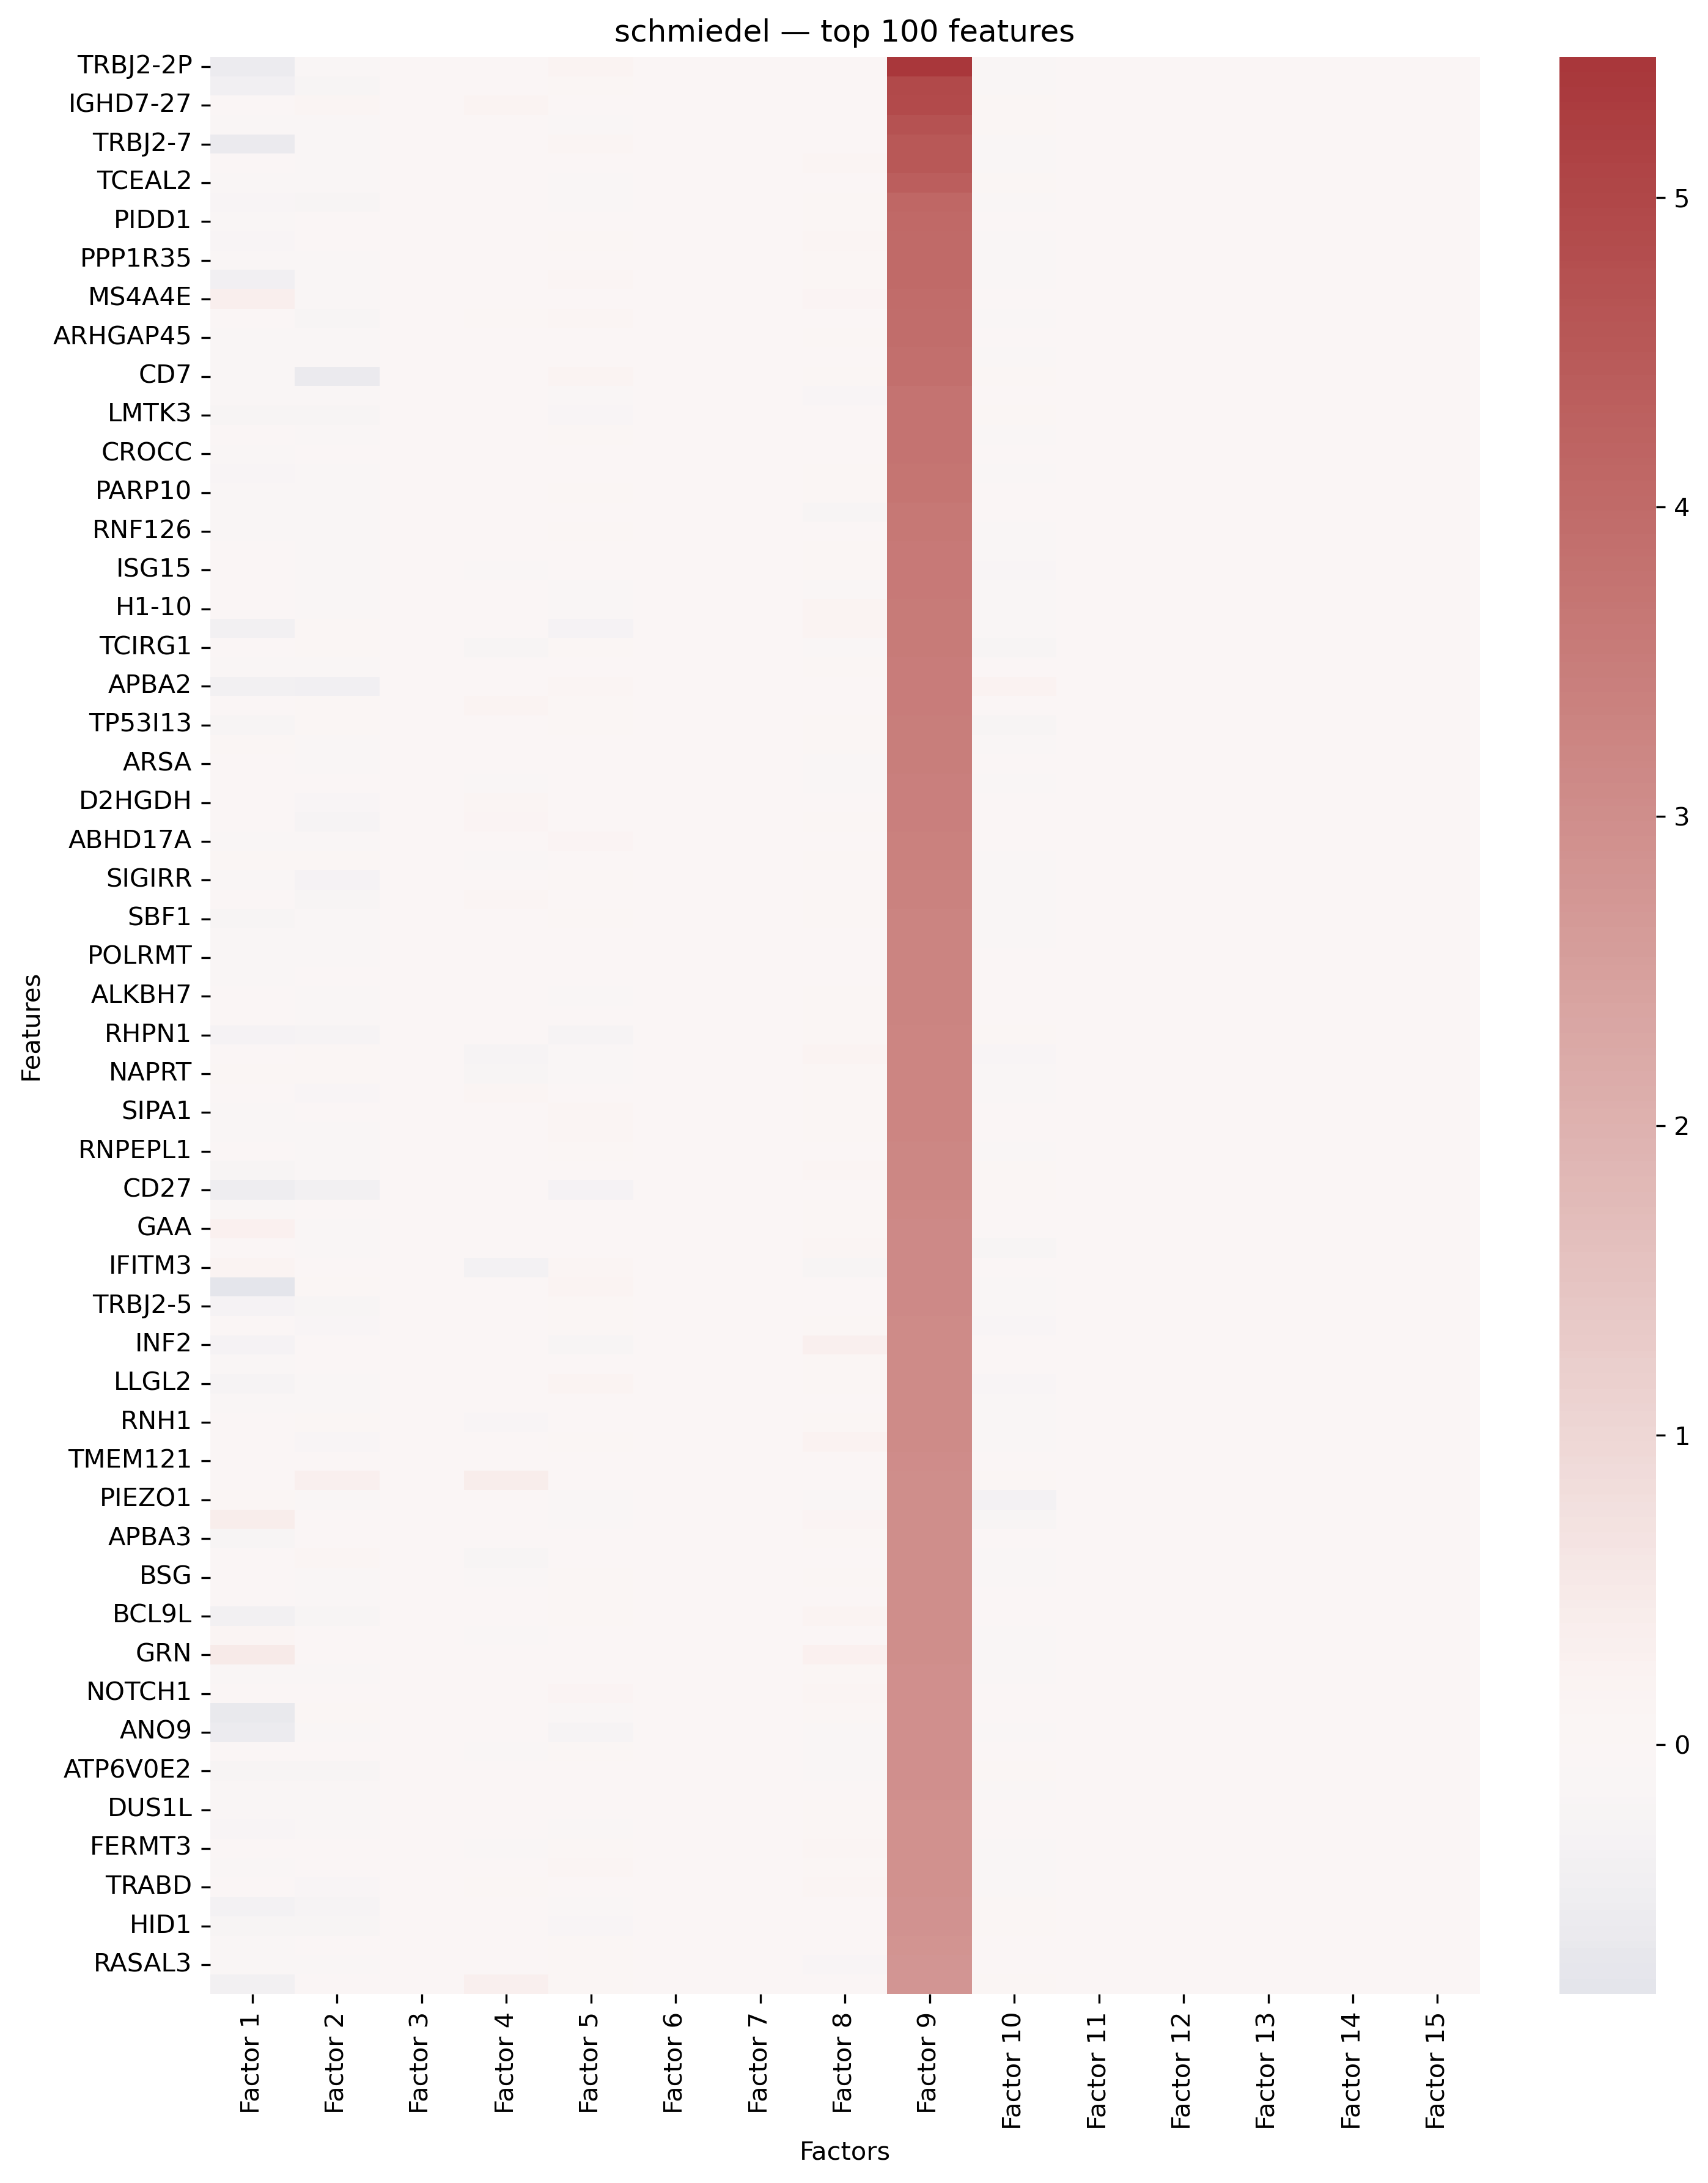

In [17]:
# plot heatmap of top features for every view in factor_loadings_dfs
top_n = 100

for view, df in factor_loadings_dfs.items():
    # pick top features by max absolute loading (most informative)
    if df.shape[0] > top_n:
        top_idx = df.abs().max(axis=1).nlargest(top_n).index
        plot_df = df.loc[top_idx]
    else:
        plot_df = df.copy()

    plt.figure(figsize=(10, max(4, plot_df.shape[0] * 0.12)))
    sns.heatmap(plot_df, cmap="vlag", center=0)
    plt.title(f"{view} — top {plot_df.shape[0]} features")
    plt.xlabel("Factors")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mofax/plot_weights.py:134: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna({"to_label": False})


<Axes: title={'center': 'schmiedel'}, xlabel='Feature weight'>

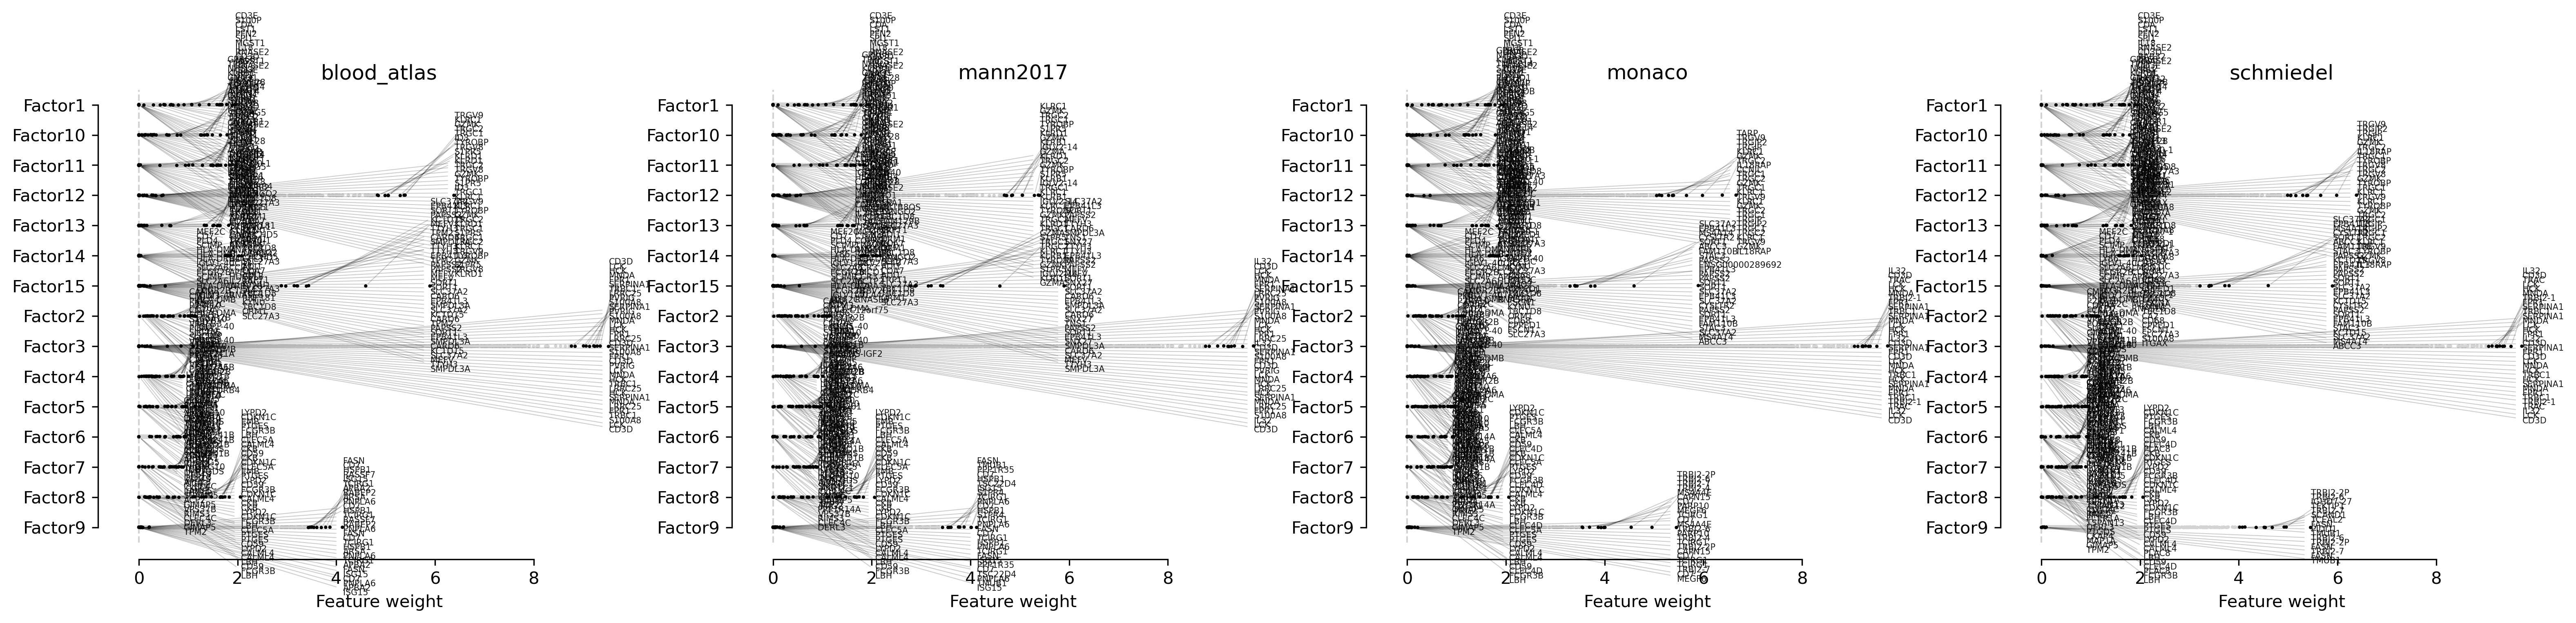

In [18]:
mfx.plot_weights(
    model,
    n_features=10,
    view="blood_atlas",
    factors=range(n_factors),
    xticklabels_size=6,
    w_abs=True,
    cmap="viridis",
    cluster_factors=False,
)

/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mofax/plot_weights.py:134: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna({"to_label": False})


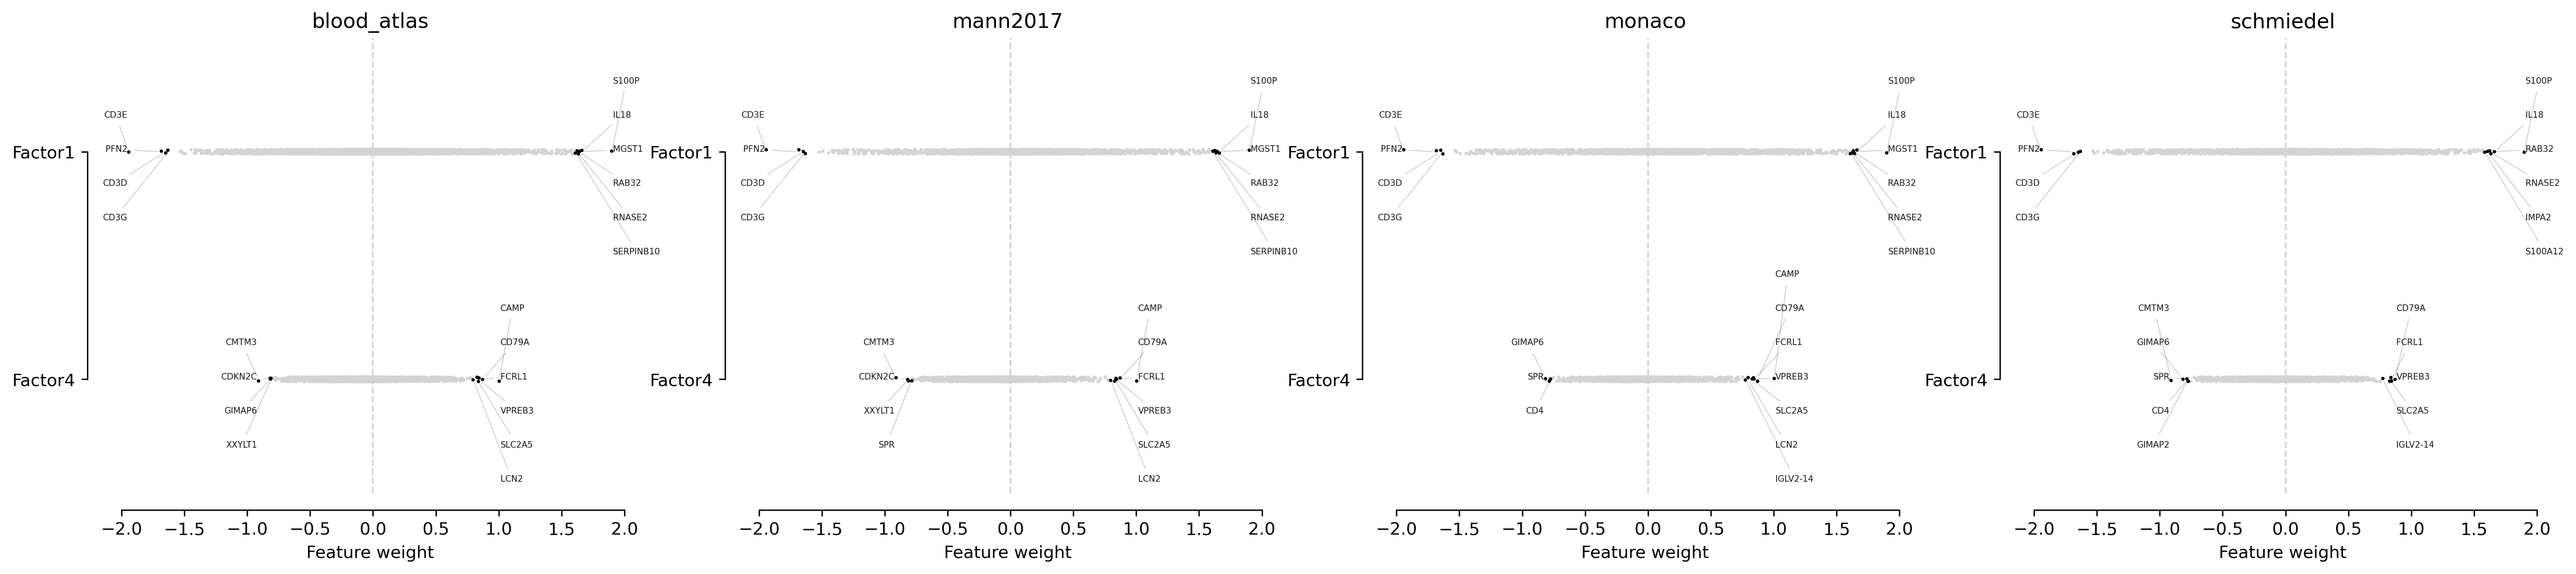

In [19]:
ax = mfx.plot_weights(
    model,
    views="blood_atlas",
    factors=[0, 3],
    n_features=10,
)

In [20]:
import decoupler as dc

msigdb = dc.op.resource("MSigDB")
msigdb = msigdb[msigdb["collection"] == "reactome_pathways"]
msigdb = msigdb[~msigdb.duplicated(["geneset", "genesymbol"])]
msigdb = msigdb.rename(columns={"geneset": "source", "genesymbol": "target"})
msigdb

target         collection  \
                                    
0         A1BG  reactome_pathways   
5         A1BG  reactome_pathways   
14        A1BG  reactome_pathways   
39        A1BG  reactome_pathways   
44        A1BG  reactome_pathways   
...        ...                ...   
5895204   ZZZ3  reactome_pathways   
5895245   ZZZ3  reactome_pathways   
5895387   ZZZ3  reactome_pathways   
5895402   ZZZ3  reactome_pathways   
5895432   ZZZ3  reactome_pathways   

                                                    source  
                                                            
0                                      REACTOME_HEMOSTASIS  
5        REACTOME_RESPONSE_TO_ELEVATED_PLATELET_CYTOSOL...  
14                           REACTOME_INNATE_IMMUNE_SYSTEM  
39       REACTOME_PLATELET_ACTIVATION_SIGNALING_AND_AGG...  
44                       REACTOME_NEUTROPHIL_DEGRANULATION  
...                                                    ...  
5895204  REACTOME_EPIGENETIC_REGULATION_BY_WDR5_CONTAIN...  
5895245  REACTOME_FORMATION_OF_WDR5_CONTAINING_HISTONE_...  
5895387                    REACTOME_CHROMATIN_ORGANIZATION  
5895402                   REACTOME_HATS_ACETYLATE_HISTONES  
5895432  REACTOME_EPIGENETIC_REGULATION_OF_GENE_EXPRESSION  

[226770 rows x 3 columns]

In [21]:
enrichment_scores, p_values = dc.mt.gsea(
    data=factor_loadings_ba_df.T, net=msigdb, tmin=1, times=5, verbose=True
)

NameError: name 'factor_loadings_ba_df' is not defined

In [ ]:
enrichment_scores, p_values

In [ ]:
significant = p_values < 0.05
rows, cols = np.where(significant)
significant_indices = [
    (
        str(p_values.index[row]),
        str(p_values.columns[col]),
        p_values.iloc[row, col],
    )
    for row, col in zip(rows, cols)
]

significant_indices_df = pd.DataFrame(
    significant_indices, columns=["Pathway", "Factor", "p-value"]
)

In [ ]:
significant_indices_df[significant_indices_df["Pathway"] == "Factor 6"][
    "Factor"
].to_list()